***
    
Demo JAX for PINN (Physics-Informed Neural Network)
    
***

    Version: 2023-03-16
    
    Author : Nicholas Sung Wei Yong, Wong Jian Cheng, Ooi Chin Chun, Abhishek Gupta

    Contain:
    
    1. PINN for solving convection-diffusion equation (1D linear convection)
    
    2. Optimize PINN using Stochastic gradient descent on the JAX framework
       -  as described in Nicholas Sung Wei Yong, Jian Cheng Wong, Pao-Hsiung Chiu, Abhishek Gupta, Chinchun Ooi, Yew-Soon Ong
       "Neuroevolution Surpasses Stochastic Gradient Descent for Physics-Informed Neural Networks" arXiv preprint arXiv:2212.07624 (2022).

Import Libraries

In [1]:
import jax
import optax
import time
import matplotlib.pyplot as plt
from typing import Any, Callable, Sequence, Optional
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax.config import config

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

PINN Architecture

In [2]:
n_nodes = 10

class PINNs(nn.Module):
    """PINNs"""
    def setup(self):
        self.layers = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                       nn.tanh,
                       nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                       nn.tanh,
                       nn.Dense(n_nodes, kernel_init = jax.nn.initializers.glorot_uniform()),
                       nn.tanh,
                       nn.Dense(1, kernel_init = jax.nn.initializers.glorot_uniform(), use_bias=False)]
        
    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        x, w = inputs[:,0:1], inputs[:,1:2]
        
        def get_u(x,w):
            u = x
            for i, lyr in enumerate(self.layers):
                u = lyr(u)
            return u
        
        u = get_u(x, w)
        
        # obtain u_x
        def get_u_x(get_u, x, w):
            u_x = jacfwd(get_u)(x, w)
            return u_x
        
        u_x_vmap = vmap(get_u_x, in_axes=(None, 0, 0))
        u_x = u_x_vmap(get_u, x, w).reshape(-1,1)  
        
        #obtain u_xx    
        def get_u_xx(get_u, x, w):
            u_xx = hessian(get_u)(x,w)
            return u_xx
        
        u_xx_vmap = vmap(get_u_xx, in_axes=(None, 0, 0))
        u_xx = u_xx_vmap(get_u, x, w).reshape(-1,1)  
        
        action = jnp.hstack([u,u_x, u_xx])   
        return action

# initialize model
model = PINNs()    

In [3]:
# choose seed
seed = 0
key1, key2 = random.split(random.PRNGKey(seed))
a = random.normal(key1, [1,1]) # Dummy input
params = model.init(key2, a) # Initialization call

In [4]:
from evojax.util import get_params_format_fn
num_params, format_params_fn = get_params_format_fn(params)
num_params

250

Problem

In [5]:
# Function to generate analytical solution
def eval_u(x, Pe, L):
    u = (1. - jnp.exp(Pe*x/L)) / (1. - jnp.exp(Pe))
    return u

def eval_Pe(u, k, L):
    return u*L/k

# f: IC/BC
def tf_bc(x):
    u = (1. - jnp.exp(Pe*x/L)) / (1. - jnp.exp(Pe))
    return u

Hyper parameters and data 

In [6]:
# choose v (PDE parameter)
v = 6

# fixed PDE & BC parameters k & L
k = 1.
L = 1.
Pe = eval_Pe(v, k, L)

# domain Boundary
x_l, x_u = 0, L

# sample size
n = 10000

# PDE data
x_pde = jnp.linspace(x_l, x_u, n)
data_pde = jnp.hstack([x_pde.reshape(-1, 1), jnp.ones((len(x_pde), 1))])
labels_pde = jnp.reshape(eval_u(x_pde, Pe, L),(-1, 1))

Loss Function

In [7]:
# loss function parameter
lmbda = 1 #500

In [8]:
def loss(params, inputs):
    x = inputs[:,0:1]
    pred = model.apply(format_params_fn(params), x)
    u, u_x, u_xx = pred[:,0:1], pred[:,1:2], pred[:,2:3]
    t_u = tf_bc(x) # ground truth
    _bc = jnp.where((jnp.equal(x, x_l) | jnp.equal(x, x_u)), 1, 0)
    bc_mse = jnp.sum(jnp.square((t_u - u)*_bc)) / jnp.sum(_bc)
    # PDE (physics laws): v*u_x = k*u_xx  
    pde = v*u_x - k*u_xx
    # exclude BC points
    _pde = jnp.where((jnp.equal(x, x_l) | jnp.equal(x, x_u)), 0, 1)
    pde = pde *_pde
    pde_mse = jnp.sum(jnp.square(pde)) / jnp.sum(_pde)
    pde_mse = pde_mse / lmbda  
    loss = pde_mse + bc_mse
    return loss
  
#loss_grad = jax.jit(jax.grad(loss))
loss_grad = jax.jit(jax.value_and_grad(loss))    

Weights Update

In [9]:
def update(params, opt_state, batch_data):
    loss_value, grad = loss_grad(params, batch_data)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

update = jit(update)

Initialization

In [10]:
# initial params
params = model.init(key2, a) # Initialization call

# flatten initial params
params = jax.flatten_util.ravel_pytree(params)[0]

Optimizer (SGD)

In [11]:
alpha = 0.001
optimizer = optax.sgd(learning_rate=alpha)
opt_state = optimizer.init(params)

Minibatching

In [12]:
BS = 100

data_bc = data_pde[(0,-1),:]
def minibatch(train_iters):
    _batch = jax.random.choice(random.PRNGKey(train_iters), n, (BS,))
    batch_data = jnp.vstack([data_pde[_batch], data_bc])
    return batch_data

minibatch = jit(minibatch)

Training 

In [13]:
# store weights
papas = {}
papas[0] = params

max_iters = 1500000
minloss = jnp.inf
fullbatchloss = jnp.inf
fullbatchloss_ls = []
runtime = 0
train_iters = 0
while (train_iters < max_iters) and (runtime < 60):
    # compute full batch loss (every 1 iterations)
    if (train_iters % 1 == 0):
        loss_value, _ = loss_grad(params, data_pde)    
        fullbatchloss = min(fullbatchloss, loss_value)
    # mini-batching
    batch_data = minibatch(train_iters)
    # stochastic update
    start = time.time()
    params, opt_state, loss_value = update(params, opt_state, batch_data)
    end = time.time()
    # store hsitory.
    runtime += (end-start)   
    fullbatchloss_ls.append([train_iters, runtime, loss_value, fullbatchloss])
    # append weights
    save_iters = [100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]
    if (train_iters in save_iters):
        papas[train_iters] = params
        #print ('iter. = %d  time = %.2fs  loss = %.2e  min. (full batch) loss = %.2e'%(train_iters, runtime, loss_value, fullbatchloss))
    # store weights when the full-batch loss is smallest
    if fullbatchloss < minloss:
        print ('iter. = %d  time = %.2fs  loss = %.2e  min. (full batch) loss = %.2e'%(train_iters, runtime, loss_value, fullbatchloss))
        minloss = fullbatchloss
        papas[-1] = params
    train_iters += 1
              
# final train_iters
print (train_iters, minloss)

iter. = 0  time = 0.81s  loss = 2.21e+01  min. (full batch) loss = 2.25e+01
iter. = 1  time = 0.81s  loss = 5.31e+00  min. (full batch) loss = 5.15e+00
iter. = 2  time = 0.81s  loss = 1.72e+00  min. (full batch) loss = 1.84e+00
iter. = 3  time = 0.81s  loss = 1.05e+00  min. (full batch) loss = 1.03e+00
iter. = 4  time = 0.81s  loss = 7.14e-01  min. (full batch) loss = 7.16e-01
iter. = 5  time = 0.81s  loss = 6.19e-01  min. (full batch) loss = 6.19e-01
iter. = 6  time = 0.81s  loss = 5.83e-01  min. (full batch) loss = 5.82e-01
iter. = 7  time = 0.81s  loss = 5.67e-01  min. (full batch) loss = 5.65e-01
iter. = 8  time = 0.81s  loss = 5.55e-01  min. (full batch) loss = 5.54e-01
iter. = 9  time = 0.81s  loss = 5.45e-01  min. (full batch) loss = 5.44e-01
iter. = 10  time = 0.81s  loss = 5.37e-01  min. (full batch) loss = 5.36e-01
iter. = 11  time = 0.81s  loss = 5.27e-01  min. (full batch) loss = 5.28e-01
iter. = 12  time = 0.81s  loss = 5.23e-01  min. (full batch) loss = 5.20e-01
iter. = 1

iter. = 203  time = 0.86s  loss = 2.72e-01  min. (full batch) loss = 2.72e-01
iter. = 204  time = 0.86s  loss = 2.67e-01  min. (full batch) loss = 2.71e-01
iter. = 205  time = 0.86s  loss = 2.68e-01  min. (full batch) loss = 2.71e-01
iter. = 206  time = 0.86s  loss = 2.71e-01  min. (full batch) loss = 2.71e-01
iter. = 207  time = 0.86s  loss = 2.69e-01  min. (full batch) loss = 2.71e-01
iter. = 208  time = 0.86s  loss = 2.72e-01  min. (full batch) loss = 2.71e-01
iter. = 209  time = 0.86s  loss = 2.68e-01  min. (full batch) loss = 2.71e-01
iter. = 210  time = 0.86s  loss = 2.67e-01  min. (full batch) loss = 2.71e-01
iter. = 211  time = 0.86s  loss = 2.73e-01  min. (full batch) loss = 2.71e-01
iter. = 212  time = 0.86s  loss = 2.75e-01  min. (full batch) loss = 2.70e-01
iter. = 213  time = 0.86s  loss = 2.68e-01  min. (full batch) loss = 2.70e-01
iter. = 214  time = 0.86s  loss = 2.70e-01  min. (full batch) loss = 2.70e-01
iter. = 215  time = 0.86s  loss = 2.74e-01  min. (full batch) lo

iter. = 432  time = 0.91s  loss = 2.56e-01  min. (full batch) loss = 2.54e-01
iter. = 433  time = 0.91s  loss = 2.55e-01  min. (full batch) loss = 2.54e-01
iter. = 434  time = 0.91s  loss = 2.54e-01  min. (full batch) loss = 2.54e-01
iter. = 435  time = 0.91s  loss = 2.55e-01  min. (full batch) loss = 2.54e-01
iter. = 436  time = 0.91s  loss = 2.55e-01  min. (full batch) loss = 2.54e-01
iter. = 437  time = 0.91s  loss = 2.54e-01  min. (full batch) loss = 2.54e-01
iter. = 438  time = 0.91s  loss = 2.52e-01  min. (full batch) loss = 2.54e-01
iter. = 439  time = 0.91s  loss = 2.54e-01  min. (full batch) loss = 2.54e-01
iter. = 440  time = 0.91s  loss = 2.55e-01  min. (full batch) loss = 2.54e-01
iter. = 441  time = 0.91s  loss = 2.54e-01  min. (full batch) loss = 2.54e-01
iter. = 442  time = 0.91s  loss = 2.54e-01  min. (full batch) loss = 2.54e-01
iter. = 443  time = 0.91s  loss = 2.53e-01  min. (full batch) loss = 2.54e-01
iter. = 444  time = 0.91s  loss = 2.53e-01  min. (full batch) lo

iter. = 664  time = 0.97s  loss = 2.50e-01  min. (full batch) loss = 2.51e-01
iter. = 665  time = 0.97s  loss = 2.51e-01  min. (full batch) loss = 2.51e-01
iter. = 666  time = 0.97s  loss = 2.50e-01  min. (full batch) loss = 2.51e-01
iter. = 667  time = 0.97s  loss = 2.51e-01  min. (full batch) loss = 2.51e-01
iter. = 668  time = 0.97s  loss = 2.51e-01  min. (full batch) loss = 2.51e-01
iter. = 669  time = 0.97s  loss = 2.50e-01  min. (full batch) loss = 2.50e-01
iter. = 670  time = 0.97s  loss = 2.50e-01  min. (full batch) loss = 2.50e-01
iter. = 672  time = 0.97s  loss = 2.50e-01  min. (full batch) loss = 2.50e-01
iter. = 674  time = 0.97s  loss = 2.50e-01  min. (full batch) loss = 2.50e-01
iter. = 676  time = 0.97s  loss = 2.51e-01  min. (full batch) loss = 2.50e-01
iter. = 677  time = 0.97s  loss = 2.50e-01  min. (full batch) loss = 2.50e-01
iter. = 678  time = 0.97s  loss = 2.51e-01  min. (full batch) loss = 2.50e-01
iter. = 679  time = 0.97s  loss = 2.50e-01  min. (full batch) lo

iter. = 1057  time = 1.06s  loss = 2.48e-01  min. (full batch) loss = 2.49e-01
iter. = 1063  time = 1.06s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 1067  time = 1.06s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 1068  time = 1.06s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 1069  time = 1.06s  loss = 2.50e-01  min. (full batch) loss = 2.49e-01
iter. = 1071  time = 1.06s  loss = 2.50e-01  min. (full batch) loss = 2.49e-01
iter. = 1075  time = 1.06s  loss = 2.48e-01  min. (full batch) loss = 2.49e-01
iter. = 1078  time = 1.07s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 1080  time = 1.07s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 1082  time = 1.07s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 1087  time = 1.07s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 1088  time = 1.07s  loss = 2.48e-01  min. (full batch) loss = 2.49e-01
iter. = 1090  time = 1.07s  loss = 2.49e-01  min. (f

iter. = 1518  time = 1.17s  loss = 2.48e-01  min. (full batch) loss = 2.49e-01
iter. = 1521  time = 1.17s  loss = 2.50e-01  min. (full batch) loss = 2.49e-01
iter. = 1522  time = 1.17s  loss = 2.48e-01  min. (full batch) loss = 2.49e-01
iter. = 1523  time = 1.17s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 1524  time = 1.17s  loss = 2.48e-01  min. (full batch) loss = 2.49e-01
iter. = 1528  time = 1.17s  loss = 2.48e-01  min. (full batch) loss = 2.49e-01
iter. = 1530  time = 1.17s  loss = 2.48e-01  min. (full batch) loss = 2.49e-01
iter. = 1531  time = 1.17s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 1532  time = 1.17s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 1533  time = 1.18s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 1535  time = 1.18s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 1538  time = 1.18s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 1539  time = 1.18s  loss = 2.50e-01  min. (f

iter. = 2005  time = 1.28s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 2006  time = 1.28s  loss = 2.48e-01  min. (full batch) loss = 2.49e-01
iter. = 2007  time = 1.28s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 2008  time = 1.28s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 2011  time = 1.28s  loss = 2.48e-01  min. (full batch) loss = 2.49e-01
iter. = 2012  time = 1.28s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 2018  time = 1.29s  loss = 2.50e-01  min. (full batch) loss = 2.49e-01
iter. = 2020  time = 1.29s  loss = 2.48e-01  min. (full batch) loss = 2.49e-01
iter. = 2022  time = 1.29s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 2024  time = 1.29s  loss = 2.49e-01  min. (full batch) loss = 2.49e-01
iter. = 2025  time = 1.29s  loss = 2.48e-01  min. (full batch) loss = 2.49e-01
iter. = 2028  time = 1.29s  loss = 2.48e-01  min. (full batch) loss = 2.49e-01
iter. = 2029  time = 1.29s  loss = 2.50e-01  min. (f

iter. = 2478  time = 1.40s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 2480  time = 1.40s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 2481  time = 1.40s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 2484  time = 1.40s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 2489  time = 1.40s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 2490  time = 1.40s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 2491  time = 1.40s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 2496  time = 1.40s  loss = 2.50e-01  min. (full batch) loss = 2.48e-01
iter. = 2498  time = 1.40s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 2499  time = 1.40s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 2500  time = 1.40s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 2501  time = 1.40s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 2503  time = 1.40s  loss = 2.48e-01  min. (f

iter. = 2952  time = 1.51s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 2954  time = 1.51s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 2955  time = 1.51s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 2970  time = 1.52s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 2971  time = 1.52s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 2976  time = 1.52s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 2980  time = 1.52s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 2986  time = 1.52s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 2989  time = 1.52s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 2992  time = 1.52s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 2997  time = 1.52s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 2998  time = 1.52s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3000  time = 1.52s  loss = 2.48e-01  min. (f

iter. = 3421  time = 1.62s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3422  time = 1.62s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3425  time = 1.62s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3426  time = 1.63s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3427  time = 1.63s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 3430  time = 1.63s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3431  time = 1.63s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3434  time = 1.63s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3444  time = 1.63s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3445  time = 1.63s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3446  time = 1.63s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3447  time = 1.63s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 3450  time = 1.63s  loss = 2.49e-01  min. (f

iter. = 3910  time = 1.74s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3911  time = 1.74s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3932  time = 1.74s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3933  time = 1.74s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 3936  time = 1.75s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 3938  time = 1.75s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3940  time = 1.75s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3942  time = 1.75s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 3947  time = 1.75s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3948  time = 1.75s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3954  time = 1.75s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 3955  time = 1.75s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 3957  time = 1.75s  loss = 2.48e-01  min. (f

iter. = 4412  time = 1.85s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 4413  time = 1.85s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 4416  time = 1.85s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 4419  time = 1.85s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 4420  time = 1.85s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 4422  time = 1.86s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 4423  time = 1.86s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 4425  time = 1.86s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 4430  time = 1.86s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 4431  time = 1.86s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 4432  time = 1.86s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 4435  time = 1.86s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 4437  time = 1.86s  loss = 2.48e-01  min. (f

iter. = 4889  time = 1.97s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 4892  time = 1.97s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 4944  time = 1.98s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 4947  time = 1.98s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 4949  time = 1.98s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 4951  time = 1.98s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 4957  time = 1.98s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 4960  time = 1.98s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 4961  time = 1.98s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 4964  time = 1.98s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 4966  time = 1.98s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 4971  time = 1.99s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 4973  time = 1.99s  loss = 2.48e-01  min. (f

iter. = 5621  time = 2.14s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 5623  time = 2.14s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 5624  time = 2.14s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 5628  time = 2.14s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 5629  time = 2.14s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 5630  time = 2.14s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 5635  time = 2.14s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 5639  time = 2.14s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 5646  time = 2.14s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 5678  time = 2.15s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 5679  time = 2.15s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 5682  time = 2.15s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 5684  time = 2.15s  loss = 2.47e-01  min. (f

iter. = 6110  time = 2.25s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 6111  time = 2.25s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 6112  time = 2.25s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 6113  time = 2.25s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 6115  time = 2.25s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 6116  time = 2.25s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 6121  time = 2.25s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 6125  time = 2.25s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 6128  time = 2.26s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 6130  time = 2.26s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 6151  time = 2.26s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 6152  time = 2.26s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 6158  time = 2.26s  loss = 2.48e-01  min. (f

iter. = 6634  time = 2.38s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 6637  time = 2.38s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 6641  time = 2.38s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 6643  time = 2.38s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 6644  time = 2.38s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 6645  time = 2.38s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 6646  time = 2.38s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 6653  time = 2.38s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 6654  time = 2.38s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 6657  time = 2.38s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 6663  time = 2.38s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 6668  time = 2.38s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 6672  time = 2.39s  loss = 2.48e-01  min. (f

iter. = 7121  time = 2.49s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 7122  time = 2.49s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 7123  time = 2.49s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 7127  time = 2.49s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 7128  time = 2.49s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 7129  time = 2.49s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 7130  time = 2.49s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 7135  time = 2.49s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 7139  time = 2.49s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 7142  time = 2.49s  loss = 2.49e-01  min. (full batch) loss = 2.48e-01
iter. = 7164  time = 2.50s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 7168  time = 2.50s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 7171  time = 2.50s  loss = 2.48e-01  min. (f

iter. = 7651  time = 2.61s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 7653  time = 2.61s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 7667  time = 2.62s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 7668  time = 2.62s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 7673  time = 2.62s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 7674  time = 2.62s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 7683  time = 2.62s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 7686  time = 2.62s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 7691  time = 2.62s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 7693  time = 2.62s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 7694  time = 2.62s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 7696  time = 2.62s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 7699  time = 2.62s  loss = 2.48e-01  min. (f

iter. = 8383  time = 2.78s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 8390  time = 2.79s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 8391  time = 2.79s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 8396  time = 2.79s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 8404  time = 2.79s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 8407  time = 2.79s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 8410  time = 2.79s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 8413  time = 2.79s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 8417  time = 2.79s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 8419  time = 2.79s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 8424  time = 2.79s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 8428  time = 2.79s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 8431  time = 2.80s  loss = 2.48e-01  min. (f

iter. = 9156  time = 2.97s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 9158  time = 2.97s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 9159  time = 2.97s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 9166  time = 2.97s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 9167  time = 2.97s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 9170  time = 2.97s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 9173  time = 2.97s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 9175  time = 2.97s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 9180  time = 2.97s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 9181  time = 2.97s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 9182  time = 2.97s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 9185  time = 2.97s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 9201  time = 2.98s  loss = 2.48e-01  min. (f

iter. = 9886  time = 3.15s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 9892  time = 3.15s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 9893  time = 3.15s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 9894  time = 3.15s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 9895  time = 3.15s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 9897  time = 3.15s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 9903  time = 3.15s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 9904  time = 3.15s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 9907  time = 3.15s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 9914  time = 3.16s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 9915  time = 3.16s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 9922  time = 3.16s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 9929  time = 3.16s  loss = 2.48e-01  min. (f

iter. = 10651  time = 3.32s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 10659  time = 3.32s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 10665  time = 3.33s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 10666  time = 3.33s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 10668  time = 3.33s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 10669  time = 3.33s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 10671  time = 3.33s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 10694  time = 3.33s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 10702  time = 3.33s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 10703  time = 3.33s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 10706  time = 3.34s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 10707  time = 3.34s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 10755  time = 3.35s  loss = 2.47

iter. = 11411  time = 3.50s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 11412  time = 3.50s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 11415  time = 3.50s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 11418  time = 3.50s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 11419  time = 3.51s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 11421  time = 3.51s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 11422  time = 3.51s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 11425  time = 3.51s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 11433  time = 3.51s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 11435  time = 3.51s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 11440  time = 3.51s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 11441  time = 3.51s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 11446  time = 3.51s  loss = 2.47

iter. = 12134  time = 3.67s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 12150  time = 3.68s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 12151  time = 3.68s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 12154  time = 3.68s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 12156  time = 3.68s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 12167  time = 3.68s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 12173  time = 3.68s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 12174  time = 3.68s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 12177  time = 3.68s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 12179  time = 3.68s  loss = 2.48e-01  min. (full batch) loss = 2.48e-01
iter. = 12181  time = 3.68s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 12182  time = 3.68s  loss = 2.47e-01  min. (full batch) loss = 2.48e-01
iter. = 12193  time = 3.69s  loss = 2.48

iter. = 13163  time = 3.91s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 13165  time = 3.91s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 13166  time = 3.91s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 13171  time = 3.92s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 13182  time = 3.92s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 13189  time = 3.92s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 13201  time = 3.92s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 13206  time = 3.92s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 13214  time = 3.92s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 13221  time = 3.93s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 13231  time = 3.93s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 13233  time = 3.93s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 13236  time = 3.93s  loss = 2.48

iter. = 13858  time = 4.08s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 13869  time = 4.08s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 13993  time = 4.12s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 13994  time = 4.12s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 13995  time = 4.12s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 13996  time = 4.12s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 13997  time = 4.12s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 14011  time = 4.12s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 14012  time = 4.12s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 14015  time = 4.12s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 14022  time = 4.12s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 14026  time = 4.13s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 14099  time = 4.14s  loss = 2.47

iter. = 15124  time = 4.39s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 15138  time = 4.40s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 15141  time = 4.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 15142  time = 4.40s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 15147  time = 4.40s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 15152  time = 4.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 15153  time = 4.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 15165  time = 4.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 15167  time = 4.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 15170  time = 4.40s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 15176  time = 4.40s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 15183  time = 4.41s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 15201  time = 4.41s  loss = 2.48

iter. = 15925  time = 4.57s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 16000  time = 4.59s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 16005  time = 4.59s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 16012  time = 4.59s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 16021  time = 4.60s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 16025  time = 4.60s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 16027  time = 4.60s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 16031  time = 4.60s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 16047  time = 4.60s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 16048  time = 4.60s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 16054  time = 4.60s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 16064  time = 4.61s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 16071  time = 4.61s  loss = 2.47

iter. = 17018  time = 4.82s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 17023  time = 4.82s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 17024  time = 4.82s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 17025  time = 4.82s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 17041  time = 4.83s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 17043  time = 4.83s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 17073  time = 4.83s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 17074  time = 4.84s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 17075  time = 4.84s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 17083  time = 4.84s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 17084  time = 4.84s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 17085  time = 4.84s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 17100  time = 4.84s  loss = 2.48

iter. = 18073  time = 5.06s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 18076  time = 5.06s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 18092  time = 5.07s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 18246  time = 5.10s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 18247  time = 5.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 18249  time = 5.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 18255  time = 5.10s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 18269  time = 5.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 18272  time = 5.11s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 18297  time = 5.11s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 18300  time = 5.11s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 18301  time = 5.11s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 18305  time = 5.11s  loss = 2.48

iter. = 19720  time = 5.44s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 19721  time = 5.44s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 19722  time = 5.44s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 19731  time = 5.45s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 19734  time = 5.45s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 19738  time = 5.45s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 19740  time = 5.45s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 19742  time = 5.45s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 19750  time = 5.45s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 19752  time = 5.45s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 19758  time = 5.45s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 19763  time = 5.45s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 19764  time = 5.45s  loss = 2.48

iter. = 21090  time = 5.77s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 21091  time = 5.77s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 21092  time = 5.78s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 21098  time = 5.78s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 21099  time = 5.78s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 21100  time = 5.78s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 21106  time = 5.78s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 21112  time = 5.78s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 21120  time = 5.78s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 21123  time = 5.78s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 21130  time = 5.79s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 21131  time = 5.79s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 21132  time = 5.79s  loss = 2.47

iter. = 22415  time = 6.09s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 22419  time = 6.09s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 22421  time = 6.09s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 22422  time = 6.09s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 22436  time = 6.09s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 22446  time = 6.10s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 22449  time = 6.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 22457  time = 6.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 22458  time = 6.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 22461  time = 6.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 22478  time = 6.10s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 22479  time = 6.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 22481  time = 6.11s  loss = 2.47

iter. = 23718  time = 6.39s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 23722  time = 6.39s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 23725  time = 6.39s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 23733  time = 6.39s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 23736  time = 6.40s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 23737  time = 6.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 23743  time = 6.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 23754  time = 6.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 23761  time = 6.40s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 23762  time = 6.40s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 23764  time = 6.40s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 23774  time = 6.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 23775  time = 6.40s  loss = 2.47

iter. = 25346  time = 6.77s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 25347  time = 6.77s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 25401  time = 6.78s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 25521  time = 6.81s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 25522  time = 6.81s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 25526  time = 6.81s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 25545  time = 6.81s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 25551  time = 6.82s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 25552  time = 6.82s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 25560  time = 6.82s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 25571  time = 6.82s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 25582  time = 6.82s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 25586  time = 6.82s  loss = 2.47

iter. = 26906  time = 7.13s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 26907  time = 7.13s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 26909  time = 7.13s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 26961  time = 7.14s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 26977  time = 7.15s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 26978  time = 7.15s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 27025  time = 7.16s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 27027  time = 7.16s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 27028  time = 7.16s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 27030  time = 7.16s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 27032  time = 7.16s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 27036  time = 7.16s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 27038  time = 7.16s  loss = 2.48

iter. = 28598  time = 7.54s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 28611  time = 7.54s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 28613  time = 7.54s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 28614  time = 7.54s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 28616  time = 7.54s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 28623  time = 7.54s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 28624  time = 7.54s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 28627  time = 7.55s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 28638  time = 7.55s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 28640  time = 7.55s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 28646  time = 7.55s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 28651  time = 7.55s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 28652  time = 7.55s  loss = 2.47

iter. = 30002  time = 7.86s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 30012  time = 7.87s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 30162  time = 7.90s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 30167  time = 7.90s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 30168  time = 7.90s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 30182  time = 7.90s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 30193  time = 7.91s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 30195  time = 7.91s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 30199  time = 7.91s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 30212  time = 7.91s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 30214  time = 7.91s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 30216  time = 7.91s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 30217  time = 7.91s  loss = 2.47

iter. = 31655  time = 8.25s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 31660  time = 8.25s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 31664  time = 8.25s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 31669  time = 8.25s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 31670  time = 8.25s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 31676  time = 8.25s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 31684  time = 8.25s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 31704  time = 8.26s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 31708  time = 8.26s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 31710  time = 8.26s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 31713  time = 8.26s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 31725  time = 8.26s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 31745  time = 8.27s  loss = 2.47

iter. = 32876  time = 8.52s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 32877  time = 8.52s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 32878  time = 8.52s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 32883  time = 8.52s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 32885  time = 8.52s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 32898  time = 8.53s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 32901  time = 8.53s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 32902  time = 8.53s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 32907  time = 8.53s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 32908  time = 8.53s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 32910  time = 8.53s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 32915  time = 8.53s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 33014  time = 8.55s  loss = 2.47

iter. = 34136  time = 8.81s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 34141  time = 8.81s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 34143  time = 8.81s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 34152  time = 8.81s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 34180  time = 8.82s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 34189  time = 8.82s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 34191  time = 8.82s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 34193  time = 8.82s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 34212  time = 8.82s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 34222  time = 8.83s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 34230  time = 8.83s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 34295  time = 8.84s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 34298  time = 8.84s  loss = 2.47

iter. = 35781  time = 9.19s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 35782  time = 9.19s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 35783  time = 9.19s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 35794  time = 9.19s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 35798  time = 9.19s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 35806  time = 9.20s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 35818  time = 9.20s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 35823  time = 9.20s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 35826  time = 9.20s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 35833  time = 9.20s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 35838  time = 9.20s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 35839  time = 9.20s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 35953  time = 9.23s  loss = 2.47

iter. = 37329  time = 9.56s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 37330  time = 9.56s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 37388  time = 9.58s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 37392  time = 9.58s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 37393  time = 9.58s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 37394  time = 9.58s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 37396  time = 9.58s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 37399  time = 9.58s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 37405  time = 9.58s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 37557  time = 9.61s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 37559  time = 9.62s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 37561  time = 9.62s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 37564  time = 9.62s  loss = 2.47

iter. = 38758  time = 9.91s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 38763  time = 9.91s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 38766  time = 9.91s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 38775  time = 9.91s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 38842  time = 9.93s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 38853  time = 9.93s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 38861  time = 9.93s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 38862  time = 9.93s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 38863  time = 9.93s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 38876  time = 9.93s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 38878  time = 9.93s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 38884  time = 9.94s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 38885  time = 9.94s  loss = 2.47

iter. = 40149  time = 10.23s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 40151  time = 10.23s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 40152  time = 10.23s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 40153  time = 10.23s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 40156  time = 10.23s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 40164  time = 10.23s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 40170  time = 10.23s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 40247  time = 10.25s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 40306  time = 10.26s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 40309  time = 10.26s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 40311  time = 10.26s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 40313  time = 10.26s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 40320  time = 10.27s

iter. = 41262  time = 10.48s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 41268  time = 10.48s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 41272  time = 10.49s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 41278  time = 10.49s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 41294  time = 10.49s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 41295  time = 10.49s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 41297  time = 10.49s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 41303  time = 10.49s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 41305  time = 10.49s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 41322  time = 10.50s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 41334  time = 10.50s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 41337  time = 10.50s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 41339  time = 10.50s

iter. = 42238  time = 10.72s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 42239  time = 10.72s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 42247  time = 10.73s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 42249  time = 10.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 42254  time = 10.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 42258  time = 10.73s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 42260  time = 10.73s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 42273  time = 10.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 42276  time = 10.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 42277  time = 10.73s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 42281  time = 10.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 42284  time = 10.73s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 42338  time = 10.75s

iter. = 43728  time = 11.07s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 43729  time = 11.07s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 43734  time = 11.07s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 43735  time = 11.07s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 43738  time = 11.07s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 43757  time = 11.07s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 43760  time = 11.07s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 43815  time = 11.09s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 43820  time = 11.09s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 43821  time = 11.09s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 43828  time = 11.09s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 43832  time = 11.09s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 43834  time = 11.09s

iter. = 45180  time = 11.40s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 45191  time = 11.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 45192  time = 11.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 45199  time = 11.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 45203  time = 11.41s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 45208  time = 11.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 45239  time = 11.42s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 45240  time = 11.42s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 45278  time = 11.43s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 45279  time = 11.43s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 45290  time = 11.43s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 45301  time = 11.43s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 45446  time = 11.47s

iter. = 46591  time = 11.74s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 46595  time = 11.74s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 46596  time = 11.74s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 46599  time = 11.75s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 46604  time = 11.75s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 46606  time = 11.75s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 46621  time = 11.75s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 46753  time = 11.78s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 46754  time = 11.78s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 46763  time = 11.79s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 46766  time = 11.79s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 46779  time = 11.79s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 46791  time = 11.79s

iter. = 47935  time = 12.07s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 47952  time = 12.08s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 47954  time = 12.08s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 47955  time = 12.08s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 47973  time = 12.08s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 47999  time = 12.09s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 48007  time = 12.09s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 48010  time = 12.09s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 48013  time = 12.09s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 48015  time = 12.09s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 48023  time = 12.09s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 48026  time = 12.09s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 48039  time = 12.10s

iter. = 49333  time = 12.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 49334  time = 12.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 49344  time = 12.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 49348  time = 12.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 49351  time = 12.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 49352  time = 12.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 49353  time = 12.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 49354  time = 12.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 49356  time = 12.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 49358  time = 12.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 49359  time = 12.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 49361  time = 12.41s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 49366  time = 12.41s

iter. = 50710  time = 12.72s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 50713  time = 12.72s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 50720  time = 12.72s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 50728  time = 12.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 50740  time = 12.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 50742  time = 12.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 50746  time = 12.73s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 50749  time = 12.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 50891  time = 12.76s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 50895  time = 12.76s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 50897  time = 12.76s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 50900  time = 12.76s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 50902  time = 12.76s

iter. = 52322  time = 13.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 52332  time = 13.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 52340  time = 13.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 52344  time = 13.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 52351  time = 13.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 52352  time = 13.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 52358  time = 13.11s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 52361  time = 13.11s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 52367  time = 13.11s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 52368  time = 13.11s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 52373  time = 13.11s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 52380  time = 13.11s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 52392  time = 13.11s

iter. = 53600  time = 13.40s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 53604  time = 13.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 53606  time = 13.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 53607  time = 13.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 53610  time = 13.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 53616  time = 13.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 53619  time = 13.40s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 53623  time = 13.40s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 53631  time = 13.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 53633  time = 13.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 53653  time = 13.41s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 53665  time = 13.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 53666  time = 13.41s

iter. = 54639  time = 13.64s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 54643  time = 13.64s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 54645  time = 13.64s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 54648  time = 13.64s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 54655  time = 13.64s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 54723  time = 13.66s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 54724  time = 13.66s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 54734  time = 13.66s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 54735  time = 13.66s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 54740  time = 13.66s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 54742  time = 13.67s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 54746  time = 13.67s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 54751  time = 13.67s

iter. = 55852  time = 13.93s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 55854  time = 13.93s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 55856  time = 13.93s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 55945  time = 13.95s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 55946  time = 13.95s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 55949  time = 13.95s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 55956  time = 13.95s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 55960  time = 13.95s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 55971  time = 13.95s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 55982  time = 13.96s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 55984  time = 13.96s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 55986  time = 13.96s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 55991  time = 13.96s

iter. = 57171  time = 14.23s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 57196  time = 14.24s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 57200  time = 14.24s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 57204  time = 14.24s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 57205  time = 14.24s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 57215  time = 14.24s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 57218  time = 14.24s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 57219  time = 14.25s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 57225  time = 14.25s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 57228  time = 14.25s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 57230  time = 14.25s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 57235  time = 14.25s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 57240  time = 14.25s

iter. = 58212  time = 14.47s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 58217  time = 14.47s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 58225  time = 14.48s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 58232  time = 14.48s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 58246  time = 14.48s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 58250  time = 14.48s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 58325  time = 14.50s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 58328  time = 14.50s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 58329  time = 14.50s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 58337  time = 14.50s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 58340  time = 14.50s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 58341  time = 14.50s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 58364  time = 14.51s

iter. = 59331  time = 14.74s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 59332  time = 14.75s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 59335  time = 14.75s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 59341  time = 14.75s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 59343  time = 14.75s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 59346  time = 14.75s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 59348  time = 14.75s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 59355  time = 14.75s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 59361  time = 14.75s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 59362  time = 14.75s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 59388  time = 14.76s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 59389  time = 14.76s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 59390  time = 14.76s

iter. = 60499  time = 15.02s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 60503  time = 15.02s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 60510  time = 15.02s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 60568  time = 15.04s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 60569  time = 15.04s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 60572  time = 15.04s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 60574  time = 15.04s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 60575  time = 15.04s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 60580  time = 15.04s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 60586  time = 15.04s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 60588  time = 15.04s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 60589  time = 15.04s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 60596  time = 15.04s

iter. = 61627  time = 15.29s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 61629  time = 15.29s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 61631  time = 15.29s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 61632  time = 15.29s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 61634  time = 15.29s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 61637  time = 15.30s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 61642  time = 15.30s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 61643  time = 15.30s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 61650  time = 15.30s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 61655  time = 15.30s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 61657  time = 15.30s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 61661  time = 15.30s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 61704  time = 15.31s

iter. = 62847  time = 15.58s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 62910  time = 15.59s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 62911  time = 15.59s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 62916  time = 15.60s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 62918  time = 15.60s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 62921  time = 15.60s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 62925  time = 15.60s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 62938  time = 15.60s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 62946  time = 15.60s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 62947  time = 15.60s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 62948  time = 15.60s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 63155  time = 15.65s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 63159  time = 15.65s

iter. = 64150  time = 15.89s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 64151  time = 15.89s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 64161  time = 15.89s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 64171  time = 15.89s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 64179  time = 15.89s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 64180  time = 15.89s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 64188  time = 15.89s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 64197  time = 15.90s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 64198  time = 15.90s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 64203  time = 15.90s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 64204  time = 15.90s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 64273  time = 15.91s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 64278  time = 15.92s

iter. = 65168  time = 16.14s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 65169  time = 16.14s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 65176  time = 16.14s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 65191  time = 16.14s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 65198  time = 16.14s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 65205  time = 16.14s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 65212  time = 16.15s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 65215  time = 16.15s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 65218  time = 16.15s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 65275  time = 16.16s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 65279  time = 16.16s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 65288  time = 16.16s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 65294  time = 16.17s

iter. = 66229  time = 16.38s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 66277  time = 16.39s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 66278  time = 16.39s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 66279  time = 16.39s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 66284  time = 16.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 66288  time = 16.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 66292  time = 16.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 66296  time = 16.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 66299  time = 16.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 66300  time = 16.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 66301  time = 16.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 66310  time = 16.40s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 66317  time = 16.40s

iter. = 67256  time = 16.62s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 67264  time = 16.63s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 67265  time = 16.63s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 67268  time = 16.63s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 67270  time = 16.63s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 67272  time = 16.63s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 67279  time = 16.63s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 67280  time = 16.63s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 67286  time = 16.63s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 67289  time = 16.63s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 67296  time = 16.63s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 67297  time = 16.63s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 67313  time = 16.64s

iter. = 68128  time = 16.82s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 68131  time = 16.82s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 68134  time = 16.82s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 68135  time = 16.82s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 68138  time = 16.82s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 68139  time = 16.82s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 68143  time = 16.83s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 68145  time = 16.83s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 68149  time = 16.83s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 68288  time = 16.86s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 68291  time = 16.86s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 68293  time = 16.86s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 68294  time = 16.86s

iter. = 69455  time = 17.14s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 69459  time = 17.15s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 69461  time = 17.15s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 69462  time = 17.15s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 69463  time = 17.15s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 69465  time = 17.15s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 69468  time = 17.15s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 69469  time = 17.15s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 69482  time = 17.15s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 69495  time = 17.15s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 69504  time = 17.16s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 69506  time = 17.16s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 69509  time = 17.16s

iter. = 70441  time = 17.38s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 70452  time = 17.39s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 70454  time = 17.39s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 70457  time = 17.39s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 70458  time = 17.39s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 70496  time = 17.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 70505  time = 17.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 70513  time = 17.41s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 70516  time = 17.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 70524  time = 17.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 70529  time = 17.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 70536  time = 17.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 70541  time = 17.41s

iter. = 71837  time = 17.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 71838  time = 17.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 71840  time = 17.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 71841  time = 17.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 71843  time = 17.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 71846  time = 17.73s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 71848  time = 17.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 71849  time = 17.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 71852  time = 17.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 71858  time = 17.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 71859  time = 17.73s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 71869  time = 17.74s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 71873  time = 17.74s

iter. = 72743  time = 17.96s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 72787  time = 17.97s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 72788  time = 17.97s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 72836  time = 17.99s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 72837  time = 17.99s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 72843  time = 17.99s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 72844  time = 17.99s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 72847  time = 17.99s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 72854  time = 17.99s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 72858  time = 17.99s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 72918  time = 18.01s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 72921  time = 18.01s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 72923  time = 18.01s

iter. = 73676  time = 18.19s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 73678  time = 18.19s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 73682  time = 18.19s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 73683  time = 18.19s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 73688  time = 18.20s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 73790  time = 18.22s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 73791  time = 18.22s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 73796  time = 18.23s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 73797  time = 18.23s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 73798  time = 18.23s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 73803  time = 18.23s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 73804  time = 18.23s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 73806  time = 18.23s

iter. = 74548  time = 18.40s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 74551  time = 18.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 74552  time = 18.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 74557  time = 18.41s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 74568  time = 18.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 74571  time = 18.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 74573  time = 18.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 74577  time = 18.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 74578  time = 18.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 74587  time = 18.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 74589  time = 18.41s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 74590  time = 18.41s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 74593  time = 18.42s

iter. = 75581  time = 18.64s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 75582  time = 18.64s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 75584  time = 18.65s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 75585  time = 18.65s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 75586  time = 18.65s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 75588  time = 18.65s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 75596  time = 18.65s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 75601  time = 18.65s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 75602  time = 18.65s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 75603  time = 18.65s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 75604  time = 18.65s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 75609  time = 18.65s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 75613  time = 18.65s

iter. = 76607  time = 18.88s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 76609  time = 18.88s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 76611  time = 18.88s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 76612  time = 18.88s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 76616  time = 18.88s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 76621  time = 18.88s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 76624  time = 18.88s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 76625  time = 18.88s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 76629  time = 18.88s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 76630  time = 18.88s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 76635  time = 18.88s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 76636  time = 18.88s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 76639  time = 18.88s

iter. = 77572  time = 19.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 77573  time = 19.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 77574  time = 19.10s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 77577  time = 19.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 77580  time = 19.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 77583  time = 19.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 77588  time = 19.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 77593  time = 19.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 77606  time = 19.10s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 77611  time = 19.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 77613  time = 19.10s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 77621  time = 19.11s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 77633  time = 19.11s

iter. = 78326  time = 19.27s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 78329  time = 19.27s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 78334  time = 19.27s  loss = 2.48e-01  min. (full batch) loss = 2.47e-01
iter. = 78344  time = 19.27s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 78350  time = 19.27s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 78362  time = 19.28s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 78363  time = 19.28s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 78418  time = 19.29s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 78419  time = 19.29s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 78420  time = 19.29s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 78424  time = 19.29s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 78430  time = 19.29s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 78539  time = 19.32s

iter. = 79334  time = 19.50s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 79340  time = 19.50s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 79343  time = 19.50s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 79345  time = 19.50s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 79351  time = 19.50s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 79355  time = 19.50s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 79362  time = 19.50s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 79370  time = 19.51s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 79372  time = 19.51s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 79374  time = 19.51s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 79379  time = 19.51s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 79382  time = 19.51s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 79383  time = 19.51s

iter. = 80142  time = 19.68s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 80144  time = 19.68s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 80158  time = 19.69s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 80160  time = 19.69s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 80162  time = 19.69s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 80168  time = 19.69s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 80173  time = 19.69s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 80183  time = 19.69s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 80185  time = 19.69s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 80186  time = 19.69s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 80225  time = 19.70s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 80226  time = 19.70s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 80228  time = 19.70s

iter. = 80951  time = 19.87s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 80956  time = 19.87s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 80958  time = 19.87s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 80959  time = 19.87s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 80960  time = 19.87s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 80966  time = 19.87s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 80968  time = 19.87s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 80969  time = 19.87s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 80970  time = 19.87s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 80973  time = 19.87s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 80978  time = 19.87s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 80980  time = 19.87s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 80982  time = 19.87s

iter. = 81694  time = 20.04s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 81696  time = 20.04s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 81697  time = 20.04s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 81698  time = 20.04s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 81705  time = 20.05s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 81706  time = 20.05s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 81711  time = 20.05s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 81714  time = 20.05s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 81720  time = 20.05s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 81733  time = 20.05s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 81734  time = 20.05s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 81743  time = 20.05s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 81745  time = 20.05s

iter. = 82460  time = 20.22s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 82464  time = 20.22s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 82465  time = 20.22s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 82469  time = 20.22s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 82470  time = 20.22s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 82481  time = 20.23s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 82483  time = 20.23s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 82489  time = 20.23s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 82490  time = 20.23s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 82491  time = 20.23s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 82499  time = 20.23s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 82502  time = 20.23s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 82509  time = 20.23s

iter. = 83467  time = 20.45s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 83468  time = 20.45s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 83470  time = 20.46s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 83473  time = 20.46s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 83475  time = 20.46s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 83479  time = 20.46s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 83480  time = 20.46s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 83484  time = 20.46s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 83488  time = 20.46s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 83492  time = 20.46s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 83497  time = 20.46s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 83498  time = 20.46s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 83504  time = 20.46s

iter. = 84403  time = 20.70s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 84405  time = 20.70s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 84406  time = 20.70s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 84407  time = 20.70s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 84409  time = 20.70s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 84412  time = 20.70s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 84414  time = 20.70s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 84417  time = 20.70s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 84418  time = 20.70s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 84422  time = 20.70s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 84425  time = 20.70s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 84427  time = 20.70s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 84430  time = 20.71s

iter. = 85147  time = 20.87s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 85156  time = 20.87s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 85160  time = 20.87s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 85234  time = 20.89s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 85239  time = 20.89s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 85240  time = 20.89s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 85246  time = 20.89s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 85247  time = 20.89s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 85248  time = 20.89s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 85253  time = 20.89s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 85257  time = 20.90s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 85263  time = 20.90s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 85265  time = 20.90s

iter. = 86334  time = 21.14s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 86386  time = 21.16s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 86389  time = 21.16s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 86391  time = 21.16s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 86393  time = 21.16s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 86395  time = 21.16s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 86400  time = 21.16s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 86402  time = 21.16s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 86403  time = 21.16s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 86464  time = 21.17s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 86468  time = 21.17s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 86469  time = 21.17s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 86470  time = 21.18s

iter. = 87159  time = 21.33s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 87210  time = 21.35s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 87214  time = 21.35s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 87220  time = 21.35s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 87224  time = 21.35s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 87226  time = 21.35s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 87227  time = 21.35s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 87228  time = 21.35s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 87239  time = 21.35s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 87240  time = 21.35s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 87241  time = 21.35s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 87243  time = 21.35s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 87249  time = 21.36s

iter. = 88046  time = 21.54s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 88047  time = 21.54s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 88048  time = 21.54s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 88058  time = 21.54s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 88061  time = 21.54s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 88062  time = 21.54s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 88063  time = 21.54s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 88065  time = 21.55s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 88079  time = 21.55s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 88085  time = 21.55s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 88086  time = 21.55s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 88087  time = 21.55s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 88092  time = 21.55s

iter. = 88828  time = 21.72s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 88831  time = 21.72s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 88833  time = 21.72s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 88838  time = 21.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 88839  time = 21.73s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 88840  time = 21.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 88842  time = 21.73s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 88845  time = 21.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 88846  time = 21.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 88848  time = 21.73s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 88850  time = 21.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 88851  time = 21.73s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 88863  time = 21.73s

iter. = 89941  time = 21.99s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 89943  time = 21.99s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 89944  time = 21.99s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 89947  time = 21.99s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 89948  time = 21.99s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 89950  time = 21.99s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 89954  time = 21.99s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 89968  time = 22.00s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 90060  time = 22.02s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 90062  time = 22.02s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 90065  time = 22.02s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 90070  time = 22.02s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 90071  time = 22.02s

iter. = 90686  time = 22.16s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 90690  time = 22.16s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 90691  time = 22.16s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 90692  time = 22.16s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 90698  time = 22.16s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 90699  time = 22.16s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 90708  time = 22.16s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 90709  time = 22.17s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 90710  time = 22.17s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 90711  time = 22.17s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 90712  time = 22.17s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 90716  time = 22.17s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 90721  time = 22.17s

iter. = 91427  time = 22.34s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 91431  time = 22.34s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 91615  time = 22.38s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 91619  time = 22.38s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 91620  time = 22.38s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 91621  time = 22.38s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 91622  time = 22.38s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 91626  time = 22.38s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 91627  time = 22.38s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 91630  time = 22.38s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 91632  time = 22.38s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 91634  time = 22.38s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 91639  time = 22.38s

iter. = 92589  time = 22.61s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 92590  time = 22.61s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 92592  time = 22.61s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 92594  time = 22.61s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 92600  time = 22.61s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 92604  time = 22.61s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 92610  time = 22.61s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 92613  time = 22.61s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 92617  time = 22.61s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 92646  time = 22.62s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 92647  time = 22.62s  loss = 2.46e-01  min. (full batch) loss = 2.47e-01
iter. = 92653  time = 22.62s  loss = 2.47e-01  min. (full batch) loss = 2.47e-01
iter. = 92666  time = 22.63s

iter. = 93367  time = 22.79s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 93368  time = 22.79s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 93375  time = 22.79s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 93378  time = 22.79s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 93380  time = 22.79s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 93383  time = 22.79s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 93386  time = 22.79s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 93388  time = 22.79s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 93393  time = 22.79s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 93397  time = 22.80s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 93401  time = 22.80s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 93404  time = 22.80s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 93410  time = 22.80s

iter. = 94045  time = 22.95s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 94052  time = 22.95s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 94058  time = 22.95s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 94089  time = 22.96s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 94090  time = 22.96s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 94094  time = 22.96s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 94101  time = 22.96s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 94107  time = 22.96s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 94109  time = 22.96s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 94114  time = 22.96s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 94117  time = 22.96s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 94124  time = 22.96s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 94128  time = 22.97s

iter. = 94864  time = 23.14s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 94878  time = 23.15s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 94884  time = 23.15s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 94891  time = 23.15s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 94892  time = 23.15s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 94898  time = 23.15s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 94904  time = 23.15s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 94908  time = 23.15s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 94910  time = 23.15s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 94914  time = 23.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 94918  time = 23.16s  loss = 2.48e-01  min. (full batch) loss = 2.46e-01
iter. = 94923  time = 23.16s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 94928  time = 23.16s

iter. = 95733  time = 23.34s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 95734  time = 23.34s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 95737  time = 23.34s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 95738  time = 23.34s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 95740  time = 23.35s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 95743  time = 23.35s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 95747  time = 23.35s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 95752  time = 23.35s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 95755  time = 23.35s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 95757  time = 23.35s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 95769  time = 23.35s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 95772  time = 23.35s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 95773  time = 23.35s

iter. = 96493  time = 23.53s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 96494  time = 23.53s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 96499  time = 23.53s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 96503  time = 23.53s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 96521  time = 23.54s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 96522  time = 23.54s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 96523  time = 23.54s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 96524  time = 23.54s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 96528  time = 23.54s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 96530  time = 23.54s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 96532  time = 23.54s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 96538  time = 23.54s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 96541  time = 23.54s

iter. = 97293  time = 23.73s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 97297  time = 23.73s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 97299  time = 23.73s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 97301  time = 23.73s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 97302  time = 23.73s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 97303  time = 23.73s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 97305  time = 23.73s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 97306  time = 23.73s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 97314  time = 23.73s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 97325  time = 23.74s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 97328  time = 23.74s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 97329  time = 23.74s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 97332  time = 23.74s

iter. = 98138  time = 23.92s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 98141  time = 23.92s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 98145  time = 23.93s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 98146  time = 23.93s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 98149  time = 23.93s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 98157  time = 23.93s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 98167  time = 23.93s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 98171  time = 23.93s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 98172  time = 23.93s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 98180  time = 23.93s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 98182  time = 23.93s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 98183  time = 23.93s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 98184  time = 23.93s

iter. = 99225  time = 24.19s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 99227  time = 24.19s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 99230  time = 24.19s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 99231  time = 24.19s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 99232  time = 24.19s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 99239  time = 24.19s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 99245  time = 24.19s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 99246  time = 24.19s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 99247  time = 24.19s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 99250  time = 24.19s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 99253  time = 24.19s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 99254  time = 24.19s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 99255  time = 24.19s

iter. = 99909  time = 24.35s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 99912  time = 24.35s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 99914  time = 24.35s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 99918  time = 24.35s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 99920  time = 24.35s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 99927  time = 24.35s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 99948  time = 24.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 99949  time = 24.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 99952  time = 24.36s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 99958  time = 24.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 99961  time = 24.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 99962  time = 24.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 99972  time = 24.37s

iter. = 100799  time = 24.56s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 100800  time = 24.56s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 100805  time = 24.56s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 100806  time = 24.56s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 100808  time = 24.56s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 100813  time = 24.56s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 100814  time = 24.56s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 100819  time = 24.56s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 100820  time = 24.56s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 100855  time = 24.57s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 100871  time = 24.57s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 100872  time = 24.57s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 100875  

iter. = 101606  time = 24.74s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 101608  time = 24.74s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 101611  time = 24.74s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 101616  time = 24.74s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 101624  time = 24.74s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 101625  time = 24.74s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 101629  time = 24.75s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 101632  time = 24.75s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 101633  time = 24.75s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 101634  time = 24.75s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 101638  time = 24.75s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 101641  time = 24.75s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 101647  

iter. = 102413  time = 24.92s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 102417  time = 24.92s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 102418  time = 24.92s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 102421  time = 24.92s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 102426  time = 24.93s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 102428  time = 24.93s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 102433  time = 24.93s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 102436  time = 24.93s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 102442  time = 24.93s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 102445  time = 24.93s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 102446  time = 24.93s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 102449  time = 24.93s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 102454  

iter. = 103415  time = 25.16s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 103417  time = 25.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 103419  time = 25.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 103421  time = 25.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 103431  time = 25.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 103438  time = 25.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 103440  time = 25.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 103441  time = 25.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 103443  time = 25.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 103445  time = 25.16s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 103448  time = 25.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 103449  time = 25.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 103451  

iter. = 104183  time = 25.34s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 104185  time = 25.34s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 104188  time = 25.35s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 104251  time = 25.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 104253  time = 25.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 104254  time = 25.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 104258  time = 25.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 104259  time = 25.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 104270  time = 25.37s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 104275  time = 25.37s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 104280  time = 25.37s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 104281  time = 25.37s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 104284  

iter. = 104910  time = 25.52s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 104911  time = 25.52s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 104912  time = 25.52s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 104913  time = 25.52s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 104915  time = 25.52s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 104921  time = 25.52s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 104923  time = 25.52s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 104926  time = 25.52s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 104928  time = 25.52s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 104934  time = 25.53s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 104936  time = 25.53s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 104943  time = 25.53s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 104962  

iter. = 105637  time = 25.69s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 105666  time = 25.70s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 105671  time = 25.70s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 105674  time = 25.70s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 105679  time = 25.70s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 105802  time = 25.73s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 105803  time = 25.73s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 105806  time = 25.73s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 105807  time = 25.73s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 105809  time = 25.73s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 105810  time = 25.73s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 105811  time = 25.73s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 105815  

iter. = 106379  time = 25.86s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 106384  time = 25.87s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 106442  time = 25.88s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 106446  time = 25.88s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 106447  time = 25.88s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 106449  time = 25.88s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 106451  time = 25.88s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 106461  time = 25.88s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 106462  time = 25.88s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 106463  time = 25.88s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 106464  time = 25.88s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 106469  time = 25.89s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 106470  

iter. = 107100  time = 26.04s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 107101  time = 26.04s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 107228  time = 26.07s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 107229  time = 26.07s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 107239  time = 26.08s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 107240  time = 26.08s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 107242  time = 26.08s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 107244  time = 26.08s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 107246  time = 26.08s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 107265  time = 26.08s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 107266  time = 26.08s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 107269  time = 26.08s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 107272  

iter. = 108055  time = 26.27s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 108059  time = 26.27s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 108061  time = 26.27s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 108069  time = 26.27s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 108093  time = 26.28s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 108100  time = 26.28s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 108109  time = 26.28s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 108110  time = 26.28s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 108112  time = 26.28s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 108116  time = 26.28s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 108119  time = 26.29s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 108120  time = 26.29s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 108121  

iter. = 108850  time = 26.46s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 108852  time = 26.46s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 108854  time = 26.47s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 108864  time = 26.47s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 108872  time = 26.47s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 108930  time = 26.48s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 108931  time = 26.48s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 108936  time = 26.48s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 108938  time = 26.49s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 108939  time = 26.49s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 108943  time = 26.49s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 109008  time = 26.50s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 109011  

iter. = 109620  time = 26.64s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 109621  time = 26.64s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 109622  time = 26.64s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 109625  time = 26.65s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 109628  time = 26.65s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 109630  time = 26.65s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 109638  time = 26.65s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 109640  time = 26.65s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 109641  time = 26.65s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 109642  time = 26.65s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 109643  time = 26.65s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 109646  time = 26.65s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 109647  

iter. = 110431  time = 26.83s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 110436  time = 26.83s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 110437  time = 26.83s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 110441  time = 26.83s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 110445  time = 26.83s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 110448  time = 26.83s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 110454  time = 26.84s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 110463  time = 26.84s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 110464  time = 26.84s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 110469  time = 26.84s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 110478  time = 26.84s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 110479  time = 26.84s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 110489  

iter. = 111173  time = 27.00s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 111176  time = 27.00s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 111181  time = 27.00s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 111182  time = 27.00s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 111186  time = 27.00s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 111189  time = 27.01s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 111190  time = 27.01s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 111193  time = 27.01s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 111194  time = 27.01s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 111198  time = 27.01s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 111200  time = 27.01s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 111201  time = 27.01s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 111206  

iter. = 111925  time = 27.18s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 111926  time = 27.18s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 111928  time = 27.18s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 111929  time = 27.18s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 111932  time = 27.18s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 111937  time = 27.18s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 111938  time = 27.18s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 111954  time = 27.18s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 111959  time = 27.18s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 112056  time = 27.21s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 112057  time = 27.21s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 112058  time = 27.21s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 112059  

iter. = 112757  time = 27.37s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 112761  time = 27.37s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 112762  time = 27.37s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 112763  time = 27.37s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 112770  time = 27.37s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 112772  time = 27.37s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 112782  time = 27.37s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 112784  time = 27.37s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 112785  time = 27.37s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 112788  time = 27.38s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 112792  time = 27.38s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 112793  time = 27.38s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 112796  

iter. = 113529  time = 27.54s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 113540  time = 27.55s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 113545  time = 27.55s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 113549  time = 27.55s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 113550  time = 27.55s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 113560  time = 27.55s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 113567  time = 27.55s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 113576  time = 27.55s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 113577  time = 27.55s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 113579  time = 27.55s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 113588  time = 27.56s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 113589  time = 27.56s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 113591  

iter. = 114565  time = 27.78s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 114568  time = 27.78s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 114569  time = 27.78s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 114571  time = 27.78s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 114572  time = 27.78s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 114585  time = 27.78s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 114587  time = 27.78s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 114608  time = 27.79s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 114614  time = 27.79s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 114615  time = 27.79s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 114658  time = 27.80s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 114660  time = 27.80s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 114661  

iter. = 115316  time = 27.96s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 115317  time = 27.96s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 115318  time = 27.96s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 115322  time = 27.96s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 115328  time = 27.96s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 115333  time = 27.96s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 115350  time = 27.96s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 115351  time = 27.96s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 115352  time = 27.96s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 115354  time = 27.96s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 115364  time = 27.97s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 115372  time = 27.97s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 115377  

iter. = 116179  time = 28.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 116180  time = 28.16s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 116186  time = 28.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 116187  time = 28.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 116190  time = 28.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 116226  time = 28.17s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 116227  time = 28.17s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 116236  time = 28.18s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 116237  time = 28.18s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 116238  time = 28.18s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 116243  time = 28.18s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 116254  time = 28.18s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 116261  

iter. = 117018  time = 28.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 117022  time = 28.37s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 117070  time = 28.38s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 117074  time = 28.38s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 117079  time = 28.38s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 117080  time = 28.38s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 117085  time = 28.38s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 117086  time = 28.38s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 117088  time = 28.38s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 117129  time = 28.39s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 117130  time = 28.39s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 117131  time = 28.39s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 117132  

iter. = 118115  time = 28.62s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 118119  time = 28.62s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 118120  time = 28.62s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 118125  time = 28.62s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 118131  time = 28.62s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 118132  time = 28.62s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 118134  time = 28.62s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 118139  time = 28.62s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 118140  time = 28.63s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 118141  time = 28.63s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 118144  time = 28.63s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 118145  time = 28.63s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 118147  

iter. = 119120  time = 28.85s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 119128  time = 28.85s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 119133  time = 28.85s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 119135  time = 28.85s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 119137  time = 28.85s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 119144  time = 28.86s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 119145  time = 28.86s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 119147  time = 28.86s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 119150  time = 28.86s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 119153  time = 28.86s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 119157  time = 28.86s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 119160  time = 28.86s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 119163  

iter. = 120192  time = 29.10s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 120199  time = 29.10s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 120200  time = 29.10s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 120208  time = 29.10s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 120211  time = 29.10s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 120212  time = 29.10s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 120215  time = 29.11s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 120221  time = 29.11s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 120225  time = 29.11s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 120233  time = 29.11s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 120238  time = 29.11s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 120241  time = 29.11s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 120247  

iter. = 121095  time = 29.31s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 121099  time = 29.32s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 121110  time = 29.32s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 121124  time = 29.32s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 121132  time = 29.32s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 121138  time = 29.33s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 121140  time = 29.33s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 121296  time = 29.36s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 121302  time = 29.37s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 121308  time = 29.37s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 121309  time = 29.37s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 121314  time = 29.37s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 121327  

iter. = 122371  time = 29.62s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 122373  time = 29.62s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 122376  time = 29.62s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 122382  time = 29.62s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 122401  time = 29.63s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 122413  time = 29.63s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 122419  time = 29.63s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 122423  time = 29.63s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 122430  time = 29.63s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 122486  time = 29.64s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 122559  time = 29.66s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 122561  time = 29.66s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 122587  

iter. = 123650  time = 29.92s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 123664  time = 29.92s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 123669  time = 29.92s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 123673  time = 29.92s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 123674  time = 29.92s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 123675  time = 29.92s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 123708  time = 29.93s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 123716  time = 29.93s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 123719  time = 29.93s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 123840  time = 29.96s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 123845  time = 29.96s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 123846  time = 29.96s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 123850  

iter. = 124678  time = 30.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 124679  time = 30.16s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 124683  time = 30.16s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 124684  time = 30.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 124686  time = 30.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 124742  time = 30.17s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 124744  time = 30.17s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 124747  time = 30.17s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 124751  time = 30.18s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 124757  time = 30.18s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 124758  time = 30.18s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 124765  time = 30.18s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 124794  

iter. = 125522  time = 30.35s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 125530  time = 30.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 125532  time = 30.36s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 125534  time = 30.36s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 125537  time = 30.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 125538  time = 30.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 125539  time = 30.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 125542  time = 30.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 125543  time = 30.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 125557  time = 30.36s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 125558  time = 30.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 125560  time = 30.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 125563  

iter. = 126634  time = 30.61s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 126635  time = 30.61s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 126644  time = 30.61s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 126646  time = 30.62s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 126649  time = 30.62s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 126654  time = 30.62s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 126659  time = 30.62s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 126666  time = 30.62s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 126669  time = 30.62s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 126696  time = 30.63s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 126697  time = 30.63s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 126699  time = 30.63s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 126700  

iter. = 127672  time = 30.85s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 127673  time = 30.85s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 127677  time = 30.85s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 127731  time = 30.87s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 127742  time = 30.87s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 127746  time = 30.87s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 127750  time = 30.87s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 127752  time = 30.87s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 127753  time = 30.87s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 127811  time = 30.89s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 127819  time = 30.89s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 127822  time = 30.89s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 127827  

iter. = 128687  time = 31.10s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 128690  time = 31.10s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 128691  time = 31.10s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 128694  time = 31.10s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 128695  time = 31.10s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 128696  time = 31.10s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 128698  time = 31.10s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 128784  time = 31.12s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 128785  time = 31.12s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 128792  time = 31.12s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 128798  time = 31.12s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 128801  time = 31.12s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 128803  

iter. = 129700  time = 31.33s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 129706  time = 31.34s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 129762  time = 31.35s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 129779  time = 31.35s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 129780  time = 31.35s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 129785  time = 31.35s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 129786  time = 31.35s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 129790  time = 31.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 129808  time = 31.36s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 129828  time = 31.36s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 129833  time = 31.37s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 129835  time = 31.37s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 129839  

iter. = 131050  time = 31.67s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 131063  time = 31.67s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 131064  time = 31.67s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 131096  time = 31.68s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 131101  time = 31.68s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 131105  time = 31.68s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 131109  time = 31.69s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 131122  time = 31.69s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 131124  time = 31.69s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 131125  time = 31.69s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 131135  time = 31.69s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 131142  time = 31.69s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 131144  

iter. = 132037  time = 31.91s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 132043  time = 31.91s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 132049  time = 31.92s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 132124  time = 31.93s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 132130  time = 31.93s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 132132  time = 31.93s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 132136  time = 31.94s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 132137  time = 31.94s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 132198  time = 31.95s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 132200  time = 31.95s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 132201  time = 31.95s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 132208  time = 31.95s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 132214  

iter. = 133056  time = 32.15s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 133057  time = 32.15s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 133058  time = 32.15s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 133063  time = 32.15s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 133066  time = 32.15s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 133077  time = 32.16s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 133079  time = 32.16s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 133214  time = 32.19s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 133215  time = 32.19s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 133224  time = 32.19s  loss = 2.46e-01  min. (full batch) loss = 2.46e-01
iter. = 133227  time = 32.19s  loss = 2.45e-01  min. (full batch) loss = 2.46e-01
iter. = 133229  time = 32.19s  loss = 2.47e-01  min. (full batch) loss = 2.46e-01
iter. = 133233  

iter. = 134313  time = 32.45s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 134314  time = 32.45s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 134322  time = 32.45s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 134324  time = 32.45s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 134327  time = 32.45s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 134328  time = 32.45s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 134336  time = 32.45s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 134346  time = 32.45s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 134351  time = 32.46s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 134354  time = 32.46s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 134405  time = 32.47s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 134413  time = 32.47s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 134418  

iter. = 135797  time = 32.79s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 135812  time = 32.80s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 135815  time = 32.80s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 135817  time = 32.80s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 135818  time = 32.80s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 135819  time = 32.80s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 135825  time = 32.80s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 135831  time = 32.80s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 135836  time = 32.80s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 135847  time = 32.80s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 135851  time = 32.81s  loss = 2.47e-01  min. (full batch) loss = 2.45e-01
iter. = 135853  time = 32.81s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 135856  

iter. = 136846  time = 33.04s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 136847  time = 33.04s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 136853  time = 33.04s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 136912  time = 33.05s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 136918  time = 33.05s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 136919  time = 33.05s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 136935  time = 33.06s  loss = 2.47e-01  min. (full batch) loss = 2.45e-01
iter. = 136941  time = 33.06s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 136947  time = 33.06s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 136956  time = 33.06s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 136987  time = 33.07s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 136988  time = 33.07s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 137011  

iter. = 137976  time = 33.30s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 137994  time = 33.30s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 138046  time = 33.32s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 138049  time = 33.32s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 138051  time = 33.32s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 138067  time = 33.32s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 138072  time = 33.32s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 138073  time = 33.32s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 138088  time = 33.33s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 138134  time = 33.34s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 138135  time = 33.34s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 138137  time = 33.34s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 138144  

iter. = 139348  time = 33.62s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 139363  time = 33.62s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 139368  time = 33.62s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 139394  time = 33.63s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 139406  time = 33.63s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 139412  time = 33.63s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 139436  time = 33.64s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 139439  time = 33.64s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 139450  time = 33.64s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 139452  time = 33.64s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 139461  time = 33.64s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 139464  time = 33.64s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 139465  

iter. = 140398  time = 33.86s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 140400  time = 33.86s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 140468  time = 33.88s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 140493  time = 33.88s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 140494  time = 33.88s  loss = 2.47e-01  min. (full batch) loss = 2.45e-01
iter. = 140499  time = 33.88s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 140504  time = 33.89s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 140507  time = 33.89s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 140509  time = 33.89s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 140544  time = 33.90s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 140626  time = 33.91s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 140628  time = 33.91s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 140629  

iter. = 141729  time = 34.17s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 141734  time = 34.17s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 141747  time = 34.18s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 141762  time = 34.18s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 141764  time = 34.18s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 141765  time = 34.18s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 141768  time = 34.18s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 141775  time = 34.18s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 141785  time = 34.18s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 141792  time = 34.19s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 141797  time = 34.19s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 141802  time = 34.19s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 141810  

iter. = 143029  time = 34.48s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 143034  time = 34.48s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 143071  time = 34.49s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 143083  time = 34.49s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 143086  time = 34.49s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 143087  time = 34.49s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 143088  time = 34.49s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 143094  time = 34.49s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 143098  time = 34.49s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 143106  time = 34.49s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 143107  time = 34.49s  loss = 2.47e-01  min. (full batch) loss = 2.45e-01
iter. = 143111  time = 34.50s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 143216  

iter. = 144297  time = 34.77s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 144301  time = 34.77s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 144322  time = 34.78s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 144323  time = 34.78s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 144330  time = 34.78s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 144335  time = 34.78s  loss = 2.47e-01  min. (full batch) loss = 2.45e-01
iter. = 144365  time = 34.79s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 144369  time = 34.79s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 144375  time = 34.79s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 144377  time = 34.79s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 144381  time = 34.79s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 144386  time = 34.79s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 144394  

iter. = 145633  time = 35.08s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 145636  time = 35.08s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 145641  time = 35.08s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 145645  time = 35.08s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 145652  time = 35.08s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 145662  time = 35.09s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 145670  time = 35.09s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 145675  time = 35.09s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 145767  time = 35.11s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 145780  time = 35.11s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 145817  time = 35.12s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 145819  time = 35.12s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 145820  

iter. = 146840  time = 35.37s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 146882  time = 35.38s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 146885  time = 35.38s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 146895  time = 35.38s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 146945  time = 35.39s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 146952  time = 35.40s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 146956  time = 35.40s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 146959  time = 35.40s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 146960  time = 35.40s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 146966  time = 35.40s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 146970  time = 35.40s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 146972  time = 35.40s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 146975  

iter. = 147968  time = 35.63s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 147969  time = 35.63s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 147973  time = 35.63s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 147974  time = 35.63s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 147976  time = 35.63s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 148007  time = 35.64s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 148009  time = 35.64s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 148011  time = 35.64s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 148014  time = 35.64s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 148015  time = 35.64s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 148017  time = 35.64s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 148018  time = 35.64s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 148025  

iter. = 149212  time = 35.92s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 149219  time = 35.92s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 149220  time = 35.92s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 149230  time = 35.92s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 149237  time = 35.93s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 149238  time = 35.93s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 149243  time = 35.93s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 149391  time = 35.96s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 149393  time = 35.96s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 149396  time = 35.96s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 149397  time = 35.96s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 149401  time = 35.96s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 149408  

iter. = 150752  time = 36.28s  loss = 2.47e-01  min. (full batch) loss = 2.45e-01
iter. = 150756  time = 36.28s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 150758  time = 36.28s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 150807  time = 36.29s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 150808  time = 36.29s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 150809  time = 36.29s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 150813  time = 36.29s  loss = 2.47e-01  min. (full batch) loss = 2.45e-01
iter. = 150826  time = 36.29s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 150827  time = 36.29s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 150863  time = 36.30s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 150868  time = 36.31s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 150876  time = 36.31s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 150877  

iter. = 152076  time = 36.59s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 152084  time = 36.59s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 152088  time = 36.59s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 152092  time = 36.59s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 152100  time = 36.60s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 152104  time = 36.60s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 152168  time = 36.61s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 152169  time = 36.61s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 152172  time = 36.61s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 152176  time = 36.61s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 152177  time = 36.61s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 152183  time = 36.61s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 152195  

iter. = 153319  time = 36.88s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 153370  time = 36.90s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 153371  time = 36.90s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 153395  time = 36.90s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 153402  time = 36.90s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 153403  time = 36.90s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 153418  time = 36.91s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 153488  time = 36.92s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 153498  time = 36.93s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 153503  time = 36.93s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 153506  time = 36.93s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 153507  time = 36.93s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 153508  

iter. = 154894  time = 37.26s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 154902  time = 37.26s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 154977  time = 37.27s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 154978  time = 37.27s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 155017  time = 37.28s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 155022  time = 37.28s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 155025  time = 37.28s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 155031  time = 37.29s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 155033  time = 37.29s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 155034  time = 37.29s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 155043  time = 37.29s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 155046  time = 37.29s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 155078  

iter. = 156473  time = 37.62s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 156534  time = 37.64s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 156543  time = 37.64s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 156585  time = 37.65s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 156587  time = 37.65s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 156622  time = 37.66s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 156627  time = 37.66s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 156630  time = 37.66s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 156631  time = 37.66s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 156635  time = 37.66s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 156638  time = 37.66s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 156639  time = 37.66s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 156646  

iter. = 157992  time = 37.97s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 157995  time = 37.97s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 157996  time = 37.97s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 157997  time = 37.97s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 157998  time = 37.97s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 158007  time = 37.97s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 158010  time = 37.97s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 158116  time = 37.99s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 158120  time = 38.00s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 158127  time = 38.00s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 158130  time = 38.00s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 158141  time = 38.00s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 158152  

iter. = 159540  time = 38.33s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 159542  time = 38.33s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 159544  time = 38.33s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 159548  time = 38.33s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 159550  time = 38.34s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 159556  time = 38.34s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 159557  time = 38.34s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 159560  time = 38.34s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 159564  time = 38.34s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 159568  time = 38.34s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 159569  time = 38.34s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 159573  time = 38.34s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 159576  

iter. = 160532  time = 38.57s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 160538  time = 38.57s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 160558  time = 38.57s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 160561  time = 38.57s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 160564  time = 38.57s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 160572  time = 38.57s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 160578  time = 38.58s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 160594  time = 38.58s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 160596  time = 38.58s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 160603  time = 38.58s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 160605  time = 38.58s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 160609  time = 38.58s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 160653  

iter. = 161803  time = 38.86s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 161807  time = 38.86s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 161808  time = 38.86s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 161811  time = 38.86s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 161823  time = 38.86s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 161826  time = 38.86s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 161837  time = 38.87s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 161846  time = 38.87s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 161849  time = 38.87s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 161850  time = 38.87s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 161856  time = 38.87s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 161858  time = 38.87s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 161861  

iter. = 162816  time = 39.09s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 162818  time = 39.09s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 162823  time = 39.10s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 162840  time = 39.10s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 162853  time = 39.10s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 162865  time = 39.11s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 162880  time = 39.11s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 162883  time = 39.11s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 162884  time = 39.11s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 162893  time = 39.11s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 162897  time = 39.11s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 162900  time = 39.11s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 162902  

iter. = 163856  time = 39.33s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 163857  time = 39.33s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 163867  time = 39.34s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 163875  time = 39.34s  loss = 2.43e-01  min. (full batch) loss = 2.45e-01
iter. = 163883  time = 39.34s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 163888  time = 39.34s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 163901  time = 39.34s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 163984  time = 39.36s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 163988  time = 39.36s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 163993  time = 39.36s  loss = 2.43e-01  min. (full batch) loss = 2.45e-01
iter. = 164033  time = 39.37s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 164034  time = 39.37s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 164035  

iter. = 165139  time = 39.62s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 165140  time = 39.62s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 165202  time = 39.64s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 165205  time = 39.64s  loss = 2.43e-01  min. (full batch) loss = 2.45e-01
iter. = 165209  time = 39.64s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 165214  time = 39.64s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 165218  time = 39.64s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 165233  time = 39.65s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 165234  time = 39.65s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 165263  time = 39.65s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 165266  time = 39.65s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 165273  time = 39.66s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 165278  

iter. = 166466  time = 39.94s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 166488  time = 39.94s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 166516  time = 39.95s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 166517  time = 39.95s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 166521  time = 39.95s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 166528  time = 39.95s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 166530  time = 39.95s  loss = 2.43e-01  min. (full batch) loss = 2.45e-01
iter. = 166549  time = 39.96s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 166552  time = 39.96s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 166553  time = 39.96s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 166597  time = 39.97s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 166601  time = 39.97s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 166614  

iter. = 167898  time = 40.27s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 167906  time = 40.28s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 167919  time = 40.28s  loss = 2.46e-01  min. (full batch) loss = 2.45e-01
iter. = 167923  time = 40.28s  loss = 2.43e-01  min. (full batch) loss = 2.45e-01
iter. = 167943  time = 40.28s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 168065  time = 40.31s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 168066  time = 40.31s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 168068  time = 40.31s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 168071  time = 40.31s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 168073  time = 40.31s  loss = 2.44e-01  min. (full batch) loss = 2.45e-01
iter. = 168083  time = 40.32s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 168085  time = 40.32s  loss = 2.45e-01  min. (full batch) loss = 2.45e-01
iter. = 168088  

iter. = 168967  time = 40.52s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 168974  time = 40.52s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 169007  time = 40.53s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 169018  time = 40.53s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 169022  time = 40.53s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 169023  time = 40.53s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 169024  time = 40.53s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 169027  time = 40.53s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 169031  time = 40.53s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 169039  time = 40.54s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 169047  time = 40.54s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 169063  time = 40.54s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 169067  

iter. = 170209  time = 40.81s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 170212  time = 40.81s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 170216  time = 40.81s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 170220  time = 40.81s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 170223  time = 40.81s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 170224  time = 40.81s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 170226  time = 40.81s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 170228  time = 40.81s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 170229  time = 40.81s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 170274  time = 40.82s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 170276  time = 40.82s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 170280  time = 40.82s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 170283  

iter. = 171243  time = 41.06s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 171250  time = 41.06s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 171297  time = 41.07s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 171314  time = 41.07s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 171316  time = 41.07s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 171317  time = 41.07s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 171319  time = 41.07s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 171321  time = 41.07s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 171325  time = 41.07s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 171334  time = 41.08s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 171336  time = 41.08s  loss = 2.46e-01  min. (full batch) loss = 2.44e-01
iter. = 171343  time = 41.08s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 171350  

iter. = 172532  time = 41.35s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 172539  time = 41.35s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 172549  time = 41.35s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 172555  time = 41.36s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 172557  time = 41.36s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 172573  time = 41.36s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 172576  time = 41.36s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 172583  time = 41.36s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 172593  time = 41.37s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 172595  time = 41.37s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 172608  time = 41.37s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 172656  time = 41.38s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 172657  

iter. = 173798  time = 41.66s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 173812  time = 41.66s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 173814  time = 41.66s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 173816  time = 41.66s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 173821  time = 41.66s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 173830  time = 41.66s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 173834  time = 41.66s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 173837  time = 41.67s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 173838  time = 41.67s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 173844  time = 41.67s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 173853  time = 41.67s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 173854  time = 41.67s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 173859  

iter. = 175050  time = 41.94s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 175054  time = 41.94s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 175060  time = 41.95s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 175062  time = 41.95s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 175063  time = 41.95s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 175065  time = 41.95s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 175069  time = 41.95s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 175085  time = 41.95s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 175086  time = 41.95s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 175121  time = 41.96s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 175124  time = 41.96s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 175146  time = 41.97s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 175148  

iter. = 176098  time = 42.18s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 176100  time = 42.18s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 176103  time = 42.18s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 176117  time = 42.19s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 176118  time = 42.19s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 176119  time = 42.19s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 176163  time = 42.20s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 176168  time = 42.20s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 176169  time = 42.20s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 176174  time = 42.20s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 176242  time = 42.22s  loss = 2.46e-01  min. (full batch) loss = 2.44e-01
iter. = 176247  time = 42.22s  loss = 2.46e-01  min. (full batch) loss = 2.44e-01
iter. = 176312  

iter. = 177357  time = 42.48s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 177365  time = 42.48s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 177367  time = 42.48s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 177369  time = 42.48s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 177373  time = 42.48s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 177376  time = 42.48s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 177420  time = 42.49s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 177423  time = 42.50s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 177425  time = 42.50s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 177426  time = 42.50s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 177432  time = 42.50s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 177448  time = 42.50s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 177449  

iter. = 178381  time = 42.72s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 178382  time = 42.72s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 178383  time = 42.73s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 178384  time = 42.73s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 178391  time = 42.73s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 178394  time = 42.73s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 178395  time = 42.73s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 178396  time = 42.73s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 178419  time = 42.73s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 178440  time = 42.74s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 178443  time = 42.74s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 178455  time = 42.74s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 178456  

iter. = 179427  time = 42.98s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 179431  time = 42.98s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 179439  time = 42.98s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 179448  time = 42.99s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 179455  time = 42.99s  loss = 2.42e-01  min. (full batch) loss = 2.44e-01
iter. = 179459  time = 42.99s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 179489  time = 43.00s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 179502  time = 43.00s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 179509  time = 43.00s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 179517  time = 43.00s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 179524  time = 43.00s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 179525  time = 43.00s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 179527  

iter. = 180705  time = 43.29s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 180706  time = 43.29s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 180709  time = 43.29s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 180712  time = 43.29s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 180745  time = 43.30s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 180760  time = 43.30s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 180765  time = 43.30s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 180769  time = 43.30s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 180837  time = 43.32s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 180865  time = 43.33s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 180871  time = 43.33s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 180874  time = 43.33s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 180876  

iter. = 181683  time = 43.52s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 181686  time = 43.52s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 181689  time = 43.52s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 181697  time = 43.52s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 181704  time = 43.52s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 181707  time = 43.52s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 181726  time = 43.53s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 181732  time = 43.53s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 181756  time = 43.53s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 181764  time = 43.53s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 181767  time = 43.54s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 181775  time = 43.54s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 181802  

iter. = 182733  time = 43.76s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 182735  time = 43.76s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 182741  time = 43.76s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 182764  time = 43.76s  loss = 2.46e-01  min. (full batch) loss = 2.44e-01
iter. = 182798  time = 43.77s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 182803  time = 43.77s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 182811  time = 43.77s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 182883  time = 43.79s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 182889  time = 43.79s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 182978  time = 43.81s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 182982  time = 43.82s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 182983  time = 43.82s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 182984  

iter. = 183731  time = 43.99s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 183735  time = 43.99s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 183739  time = 43.99s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 183753  time = 44.00s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 183758  time = 44.00s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 183760  time = 44.00s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 183761  time = 44.00s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 183772  time = 44.00s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 183780  time = 44.00s  loss = 2.46e-01  min. (full batch) loss = 2.44e-01
iter. = 183804  time = 44.01s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 183805  time = 44.01s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 183810  time = 44.01s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 183812  

iter. = 184793  time = 44.23s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 184800  time = 44.23s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 184804  time = 44.24s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 184815  time = 44.24s  loss = 2.42e-01  min. (full batch) loss = 2.44e-01
iter. = 184818  time = 44.24s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 184822  time = 44.24s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 184837  time = 44.25s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 184841  time = 44.25s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 184844  time = 44.25s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 184849  time = 44.25s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 184857  time = 44.25s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 184868  time = 44.26s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 184873  

iter. = 185757  time = 44.47s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 185762  time = 44.47s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 185769  time = 44.47s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 185777  time = 44.48s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 185779  time = 44.48s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 185780  time = 44.48s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 185782  time = 44.48s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 185784  time = 44.48s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 185786  time = 44.48s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 185789  time = 44.48s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 185792  time = 44.48s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 185793  time = 44.48s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 185794  

iter. = 186692  time = 44.69s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 186695  time = 44.69s  loss = 2.46e-01  min. (full batch) loss = 2.44e-01
iter. = 186699  time = 44.69s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 186703  time = 44.69s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 186707  time = 44.69s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 186714  time = 44.69s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 186716  time = 44.69s  loss = 2.43e-01  min. (full batch) loss = 2.44e-01
iter. = 186719  time = 44.70s  loss = 2.45e-01  min. (full batch) loss = 2.44e-01
iter. = 186722  time = 44.70s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 186738  time = 44.70s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 186739  time = 44.70s  loss = 2.42e-01  min. (full batch) loss = 2.44e-01
iter. = 186749  time = 44.70s  loss = 2.44e-01  min. (full batch) loss = 2.44e-01
iter. = 186757  

iter. = 187417  time = 44.86s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 187423  time = 44.86s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 187426  time = 44.86s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 187429  time = 44.86s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 187432  time = 44.86s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 187442  time = 44.87s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 187449  time = 44.87s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 187498  time = 44.88s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 187516  time = 44.88s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 187524  time = 44.88s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 187529  time = 44.89s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 187532  time = 44.89s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 187533  

iter. = 188178  time = 45.04s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 188185  time = 45.04s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 188187  time = 45.04s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 188188  time = 45.04s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 188190  time = 45.04s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 188193  time = 45.04s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 188204  time = 45.04s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 188235  time = 45.05s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 188240  time = 45.05s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 188243  time = 45.05s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 188252  time = 45.06s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 188289  time = 45.06s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 188292  

iter. = 189365  time = 45.32s  loss = 2.45e-01  min. (full batch) loss = 2.43e-01
iter. = 189370  time = 45.32s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 189371  time = 45.32s  loss = 2.45e-01  min. (full batch) loss = 2.43e-01
iter. = 189376  time = 45.32s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 189389  time = 45.33s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 189391  time = 45.33s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 189394  time = 45.33s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 189397  time = 45.33s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 189410  time = 45.33s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 189414  time = 45.33s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 189418  time = 45.33s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 189422  time = 45.33s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 189427  

iter. = 190472  time = 45.57s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 190477  time = 45.57s  loss = 2.45e-01  min. (full batch) loss = 2.43e-01
iter. = 190490  time = 45.58s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 190504  time = 45.58s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 190511  time = 45.58s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 190514  time = 45.58s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 190522  time = 45.58s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 190566  time = 45.59s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 190569  time = 45.59s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 190576  time = 45.60s  loss = 2.45e-01  min. (full batch) loss = 2.43e-01
iter. = 190583  time = 45.60s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 190588  time = 45.60s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 190596  

iter. = 191437  time = 45.80s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 191441  time = 45.80s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 191444  time = 45.81s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 191446  time = 45.81s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 191449  time = 45.81s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 191450  time = 45.81s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 191472  time = 45.81s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 191480  time = 45.82s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 191489  time = 45.82s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 191490  time = 45.82s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 191493  time = 45.82s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 191500  time = 45.82s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 191501  

iter. = 192472  time = 46.04s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 192474  time = 46.05s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 192477  time = 46.05s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 192482  time = 46.05s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 192483  time = 46.05s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 192485  time = 46.05s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 192521  time = 46.06s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 192528  time = 46.06s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 192580  time = 46.07s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 192583  time = 46.07s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 192593  time = 46.07s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 192601  time = 46.07s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 192602  

iter. = 193534  time = 46.29s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 193540  time = 46.29s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 193541  time = 46.29s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 193542  time = 46.29s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 193583  time = 46.30s  loss = 2.45e-01  min. (full batch) loss = 2.43e-01
iter. = 193588  time = 46.30s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 193595  time = 46.30s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 193601  time = 46.30s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 193634  time = 46.31s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 193650  time = 46.31s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 193654  time = 46.31s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 193658  time = 46.31s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 193659  

iter. = 194539  time = 46.52s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 194544  time = 46.52s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 194556  time = 46.52s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 194568  time = 46.52s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 194570  time = 46.52s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 194585  time = 46.53s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 194587  time = 46.53s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 194589  time = 46.53s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 194597  time = 46.53s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 194608  time = 46.53s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 194618  time = 46.53s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 194623  time = 46.54s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 194626  

iter. = 195571  time = 46.76s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 195575  time = 46.76s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 195581  time = 46.76s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 195584  time = 46.76s  loss = 2.45e-01  min. (full batch) loss = 2.43e-01
iter. = 195586  time = 46.76s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 195591  time = 46.76s  loss = 2.45e-01  min. (full batch) loss = 2.43e-01
iter. = 195613  time = 46.77s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 195618  time = 46.77s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 195629  time = 46.77s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 195672  time = 46.78s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 195674  time = 46.78s  loss = 2.41e-01  min. (full batch) loss = 2.43e-01
iter. = 195679  time = 46.78s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 195687  

iter. = 196603  time = 47.00s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 196605  time = 47.00s  loss = 2.45e-01  min. (full batch) loss = 2.43e-01
iter. = 196614  time = 47.00s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 196616  time = 47.00s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 196650  time = 47.01s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 196655  time = 47.01s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 196658  time = 47.01s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 196664  time = 47.02s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 196667  time = 47.02s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 196672  time = 47.02s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 196674  time = 47.02s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 196682  time = 47.02s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 196685  

iter. = 197808  time = 47.29s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 197809  time = 47.29s  loss = 2.41e-01  min. (full batch) loss = 2.43e-01
iter. = 197815  time = 47.29s  loss = 2.41e-01  min. (full batch) loss = 2.43e-01
iter. = 197827  time = 47.29s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 197867  time = 47.30s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 197872  time = 47.30s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 197873  time = 47.30s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 197877  time = 47.31s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 197879  time = 47.31s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 197888  time = 47.31s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 197889  time = 47.31s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 197892  time = 47.31s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 197903  

iter. = 198820  time = 47.52s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 198831  time = 47.52s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 198832  time = 47.52s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 198837  time = 47.53s  loss = 2.41e-01  min. (full batch) loss = 2.43e-01
iter. = 198847  time = 47.53s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 198850  time = 47.53s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 198856  time = 47.53s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 198859  time = 47.53s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 198871  time = 47.53s  loss = 2.44e-01  min. (full batch) loss = 2.43e-01
iter. = 198875  time = 47.53s  loss = 2.43e-01  min. (full batch) loss = 2.43e-01
iter. = 198877  time = 47.53s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 198896  time = 47.54s  loss = 2.42e-01  min. (full batch) loss = 2.43e-01
iter. = 198902  

iter. = 199863  time = 47.76s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 199878  time = 47.76s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 199880  time = 47.76s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 199882  time = 47.76s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 199886  time = 47.77s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 199898  time = 47.77s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 199936  time = 47.78s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 199965  time = 47.78s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 199968  time = 47.79s  loss = 2.44e-01  min. (full batch) loss = 2.42e-01
iter. = 199969  time = 47.79s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 199997  time = 47.79s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 199999  time = 47.79s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 200000  

iter. = 200875  time = 48.00s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 200876  time = 48.00s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 200879  time = 48.00s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 200889  time = 48.00s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 200905  time = 48.00s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 200906  time = 48.00s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 200926  time = 48.01s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 200937  time = 48.01s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 200948  time = 48.01s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 200955  time = 48.02s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 200960  time = 48.02s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 200976  time = 48.02s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 200978  

iter. = 202178  time = 48.29s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 202180  time = 48.29s  loss = 2.44e-01  min. (full batch) loss = 2.42e-01
iter. = 202182  time = 48.29s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 202183  time = 48.29s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 202188  time = 48.29s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 202194  time = 48.29s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 202197  time = 48.29s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 202201  time = 48.30s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 202203  time = 48.30s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 202217  time = 48.30s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 202219  time = 48.30s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 202233  time = 48.30s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 202240  

iter. = 203193  time = 48.52s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 203196  time = 48.52s  loss = 2.44e-01  min. (full batch) loss = 2.42e-01
iter. = 203212  time = 48.53s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 203216  time = 48.53s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 203225  time = 48.53s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 203227  time = 48.53s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 203232  time = 48.53s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 203237  time = 48.53s  loss = 2.45e-01  min. (full batch) loss = 2.42e-01
iter. = 203242  time = 48.54s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 203244  time = 48.54s  loss = 2.44e-01  min. (full batch) loss = 2.42e-01
iter. = 203250  time = 48.54s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 203253  time = 48.54s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 203255  

iter. = 204282  time = 48.77s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 204283  time = 48.77s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 204284  time = 48.77s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 204287  time = 48.77s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 204318  time = 48.78s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 204323  time = 48.78s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 204329  time = 48.78s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 204334  time = 48.78s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 204397  time = 48.80s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 204399  time = 48.80s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 204406  time = 48.80s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 204421  time = 48.80s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 204428  

iter. = 205579  time = 49.07s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 205591  time = 49.07s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 205609  time = 49.08s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 205612  time = 49.08s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 205615  time = 49.08s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 205631  time = 49.08s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 205662  time = 49.09s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 205691  time = 49.10s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 205701  time = 49.10s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 205706  time = 49.10s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 205707  time = 49.10s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 205711  time = 49.10s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 205714  

iter. = 206536  time = 49.30s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 206548  time = 49.30s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 206564  time = 49.31s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 206566  time = 49.31s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 206610  time = 49.32s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 206614  time = 49.32s  loss = 2.40e-01  min. (full batch) loss = 2.42e-01
iter. = 206651  time = 49.33s  loss = 2.44e-01  min. (full batch) loss = 2.42e-01
iter. = 206669  time = 49.33s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 206680  time = 49.33s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 206687  time = 49.34s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 206732  time = 49.35s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 206735  time = 49.35s  loss = 2.40e-01  min. (full batch) loss = 2.42e-01
iter. = 206743  

iter. = 207742  time = 49.59s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 207743  time = 49.59s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 207759  time = 49.60s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 207794  time = 49.61s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 207801  time = 49.61s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 207802  time = 49.61s  loss = 2.40e-01  min. (full batch) loss = 2.42e-01
iter. = 207822  time = 49.61s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 207831  time = 49.61s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 207832  time = 49.61s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 207842  time = 49.62s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 207843  time = 49.62s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 207898  time = 49.63s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 207902  

iter. = 208973  time = 49.89s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 208974  time = 49.89s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 209006  time = 49.90s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 209010  time = 49.90s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 209029  time = 49.90s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 209044  time = 49.91s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 209052  time = 49.91s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 209055  time = 49.91s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 209099  time = 49.92s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 209113  time = 49.92s  loss = 2.40e-01  min. (full batch) loss = 2.42e-01
iter. = 209146  time = 49.93s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 209157  time = 49.94s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 209165  

iter. = 210495  time = 50.25s  loss = 2.40e-01  min. (full batch) loss = 2.42e-01
iter. = 210514  time = 50.26s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 210551  time = 50.27s  loss = 2.41e-01  min. (full batch) loss = 2.42e-01
iter. = 210557  time = 50.27s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 210571  time = 50.27s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 210572  time = 50.27s  loss = 2.40e-01  min. (full batch) loss = 2.42e-01
iter. = 210576  time = 50.27s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 210585  time = 50.28s  loss = 2.42e-01  min. (full batch) loss = 2.42e-01
iter. = 210597  time = 50.28s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 210609  time = 50.28s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 210652  time = 50.29s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 210657  time = 50.29s  loss = 2.43e-01  min. (full batch) loss = 2.42e-01
iter. = 210665  

iter. = 211975  time = 50.61s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 211984  time = 50.61s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 211996  time = 50.61s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 212000  time = 50.61s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 212045  time = 50.62s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 212046  time = 50.62s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 212047  time = 50.62s  loss = 2.40e-01  min. (full batch) loss = 2.41e-01
iter. = 212050  time = 50.62s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 212055  time = 50.63s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 212080  time = 50.63s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 212081  time = 50.63s  loss = 2.43e-01  min. (full batch) loss = 2.41e-01
iter. = 212091  time = 50.63s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 212092  

iter. = 213314  time = 50.93s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 213354  time = 50.94s  loss = 2.44e-01  min. (full batch) loss = 2.41e-01
iter. = 213371  time = 50.94s  loss = 2.43e-01  min. (full batch) loss = 2.41e-01
iter. = 213381  time = 50.95s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 213455  time = 50.96s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 213456  time = 50.96s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 213474  time = 50.97s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 213478  time = 50.97s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 213501  time = 50.97s  loss = 2.40e-01  min. (full batch) loss = 2.41e-01
iter. = 213508  time = 50.98s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 213548  time = 50.98s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 213553  time = 50.99s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 213554  

iter. = 214881  time = 51.29s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 214914  time = 51.30s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 214917  time = 51.30s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 214923  time = 51.30s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 214930  time = 51.31s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 214939  time = 51.31s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 214955  time = 51.31s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 214960  time = 51.31s  loss = 2.40e-01  min. (full batch) loss = 2.41e-01
iter. = 215013  time = 51.33s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 215014  time = 51.33s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 215022  time = 51.33s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 215024  time = 51.33s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 215025  

iter. = 216210  time = 51.60s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 216233  time = 51.61s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 216292  time = 51.62s  loss = 2.40e-01  min. (full batch) loss = 2.41e-01
iter. = 216301  time = 51.62s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 216331  time = 51.63s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 216332  time = 51.63s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 216335  time = 51.63s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 216341  time = 51.63s  loss = 2.40e-01  min. (full batch) loss = 2.41e-01
iter. = 216358  time = 51.63s  loss = 2.40e-01  min. (full batch) loss = 2.41e-01
iter. = 216365  time = 51.64s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 216366  time = 51.64s  loss = 2.40e-01  min. (full batch) loss = 2.41e-01
iter. = 216374  time = 51.64s  loss = 2.40e-01  min. (full batch) loss = 2.41e-01
iter. = 216380  

iter. = 217948  time = 52.00s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 217951  time = 52.00s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 217954  time = 52.00s  loss = 2.39e-01  min. (full batch) loss = 2.41e-01
iter. = 217956  time = 52.00s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 217957  time = 52.00s  loss = 2.40e-01  min. (full batch) loss = 2.41e-01
iter. = 217965  time = 52.00s  loss = 2.40e-01  min. (full batch) loss = 2.41e-01
iter. = 217977  time = 52.01s  loss = 2.40e-01  min. (full batch) loss = 2.41e-01
iter. = 217983  time = 52.01s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 217994  time = 52.01s  loss = 2.39e-01  min. (full batch) loss = 2.41e-01
iter. = 218008  time = 52.01s  loss = 2.40e-01  min. (full batch) loss = 2.41e-01
iter. = 218010  time = 52.01s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 218021  time = 52.02s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 218031  

iter. = 219521  time = 52.36s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 219525  time = 52.36s  loss = 2.43e-01  min. (full batch) loss = 2.41e-01
iter. = 219528  time = 52.37s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 219553  time = 52.37s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 219587  time = 52.38s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 219591  time = 52.38s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 219596  time = 52.38s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 219599  time = 52.38s  loss = 2.40e-01  min. (full batch) loss = 2.41e-01
iter. = 219629  time = 52.39s  loss = 2.44e-01  min. (full batch) loss = 2.41e-01
iter. = 219643  time = 52.40s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 219650  time = 52.40s  loss = 2.40e-01  min. (full batch) loss = 2.41e-01
iter. = 219669  time = 52.40s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 219689  

iter. = 221252  time = 52.78s  loss = 2.40e-01  min. (full batch) loss = 2.41e-01
iter. = 221261  time = 52.78s  loss = 2.39e-01  min. (full batch) loss = 2.41e-01
iter. = 221270  time = 52.79s  loss = 2.39e-01  min. (full batch) loss = 2.41e-01
iter. = 221275  time = 52.79s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 221279  time = 52.79s  loss = 2.39e-01  min. (full batch) loss = 2.41e-01
iter. = 221282  time = 52.79s  loss = 2.43e-01  min. (full batch) loss = 2.41e-01
iter. = 221336  time = 52.80s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 221342  time = 52.80s  loss = 2.41e-01  min. (full batch) loss = 2.41e-01
iter. = 221345  time = 52.80s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 221358  time = 52.81s  loss = 2.42e-01  min. (full batch) loss = 2.41e-01
iter. = 221460  time = 52.83s  loss = 2.38e-01  min. (full batch) loss = 2.41e-01
iter. = 221497  time = 52.84s  loss = 2.40e-01  min. (full batch) loss = 2.41e-01
iter. = 221540  

iter. = 223137  time = 53.22s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 223161  time = 53.23s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 223166  time = 53.23s  loss = 2.42e-01  min. (full batch) loss = 2.40e-01
iter. = 223231  time = 53.24s  loss = 2.39e-01  min. (full batch) loss = 2.40e-01
iter. = 223233  time = 53.25s  loss = 2.43e-01  min. (full batch) loss = 2.40e-01
iter. = 223235  time = 53.25s  loss = 2.39e-01  min. (full batch) loss = 2.40e-01
iter. = 223251  time = 53.25s  loss = 2.41e-01  min. (full batch) loss = 2.40e-01
iter. = 223279  time = 53.26s  loss = 2.41e-01  min. (full batch) loss = 2.40e-01
iter. = 223297  time = 53.26s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 223334  time = 53.27s  loss = 2.42e-01  min. (full batch) loss = 2.40e-01
iter. = 223335  time = 53.27s  loss = 2.39e-01  min. (full batch) loss = 2.40e-01
iter. = 223359  time = 53.28s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 223400  

iter. = 224916  time = 53.65s  loss = 2.42e-01  min. (full batch) loss = 2.40e-01
iter. = 224928  time = 53.66s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 224938  time = 53.66s  loss = 2.38e-01  min. (full batch) loss = 2.40e-01
iter. = 224970  time = 53.67s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 224979  time = 53.67s  loss = 2.39e-01  min. (full batch) loss = 2.40e-01
iter. = 225019  time = 53.68s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 225020  time = 53.68s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 225034  time = 53.68s  loss = 2.41e-01  min. (full batch) loss = 2.40e-01
iter. = 225059  time = 53.69s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 225073  time = 53.69s  loss = 2.43e-01  min. (full batch) loss = 2.40e-01
iter. = 225116  time = 53.70s  loss = 2.39e-01  min. (full batch) loss = 2.40e-01
iter. = 225119  time = 53.70s  loss = 2.42e-01  min. (full batch) loss = 2.40e-01
iter. = 225121  

iter. = 226493  time = 54.02s  loss = 2.39e-01  min. (full batch) loss = 2.40e-01
iter. = 226496  time = 54.02s  loss = 2.41e-01  min. (full batch) loss = 2.40e-01
iter. = 226498  time = 54.02s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 226591  time = 54.04s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 226593  time = 54.04s  loss = 2.42e-01  min. (full batch) loss = 2.40e-01
iter. = 226597  time = 54.04s  loss = 2.41e-01  min. (full batch) loss = 2.40e-01
iter. = 226599  time = 54.04s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 226647  time = 54.05s  loss = 2.42e-01  min. (full batch) loss = 2.40e-01
iter. = 226659  time = 54.06s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 226660  time = 54.06s  loss = 2.38e-01  min. (full batch) loss = 2.40e-01
iter. = 226664  time = 54.06s  loss = 2.41e-01  min. (full batch) loss = 2.40e-01
iter. = 226693  time = 54.06s  loss = 2.42e-01  min. (full batch) loss = 2.40e-01
iter. = 226704  

iter. = 228311  time = 54.45s  loss = 2.41e-01  min. (full batch) loss = 2.40e-01
iter. = 228337  time = 54.46s  loss = 2.42e-01  min. (full batch) loss = 2.40e-01
iter. = 228356  time = 54.46s  loss = 2.42e-01  min. (full batch) loss = 2.40e-01
iter. = 228402  time = 54.47s  loss = 2.39e-01  min. (full batch) loss = 2.40e-01
iter. = 228408  time = 54.47s  loss = 2.39e-01  min. (full batch) loss = 2.40e-01
iter. = 228415  time = 54.47s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 228425  time = 54.48s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 228431  time = 54.48s  loss = 2.41e-01  min. (full batch) loss = 2.40e-01
iter. = 228453  time = 54.48s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 228477  time = 54.49s  loss = 2.41e-01  min. (full batch) loss = 2.40e-01
iter. = 228503  time = 54.49s  loss = 2.39e-01  min. (full batch) loss = 2.40e-01
iter. = 228523  time = 54.50s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 228548  

iter. = 229806  time = 54.81s  loss = 2.39e-01  min. (full batch) loss = 2.40e-01
iter. = 229854  time = 54.82s  loss = 2.39e-01  min. (full batch) loss = 2.40e-01
iter. = 229859  time = 54.82s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 229867  time = 54.82s  loss = 2.39e-01  min. (full batch) loss = 2.40e-01
iter. = 229869  time = 54.82s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 229900  time = 54.83s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 229901  time = 54.83s  loss = 2.39e-01  min. (full batch) loss = 2.40e-01
iter. = 229940  time = 54.84s  loss = 2.41e-01  min. (full batch) loss = 2.40e-01
iter. = 229960  time = 54.84s  loss = 2.41e-01  min. (full batch) loss = 2.40e-01
iter. = 229968  time = 54.85s  loss = 2.38e-01  min. (full batch) loss = 2.40e-01
iter. = 229972  time = 54.85s  loss = 2.39e-01  min. (full batch) loss = 2.40e-01
iter. = 229973  time = 54.85s  loss = 2.39e-01  min. (full batch) loss = 2.40e-01
iter. = 230012  

iter. = 231559  time = 55.22s  loss = 2.42e-01  min. (full batch) loss = 2.40e-01
iter. = 231585  time = 55.23s  loss = 2.38e-01  min. (full batch) loss = 2.40e-01
iter. = 231648  time = 55.24s  loss = 2.39e-01  min. (full batch) loss = 2.40e-01
iter. = 231650  time = 55.24s  loss = 2.41e-01  min. (full batch) loss = 2.40e-01
iter. = 231658  time = 55.24s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 231673  time = 55.25s  loss = 2.41e-01  min. (full batch) loss = 2.40e-01
iter. = 231677  time = 55.25s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 231681  time = 55.25s  loss = 2.41e-01  min. (full batch) loss = 2.40e-01
iter. = 231683  time = 55.25s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 231688  time = 55.25s  loss = 2.39e-01  min. (full batch) loss = 2.40e-01
iter. = 231706  time = 55.25s  loss = 2.40e-01  min. (full batch) loss = 2.40e-01
iter. = 231707  time = 55.25s  loss = 2.41e-01  min. (full batch) loss = 2.40e-01
iter. = 231710  

iter. = 233210  time = 55.59s  loss = 2.40e-01  min. (full batch) loss = 2.39e-01
iter. = 233213  time = 55.60s  loss = 2.40e-01  min. (full batch) loss = 2.39e-01
iter. = 233222  time = 55.60s  loss = 2.40e-01  min. (full batch) loss = 2.39e-01
iter. = 233226  time = 55.60s  loss = 2.37e-01  min. (full batch) loss = 2.39e-01
iter. = 233243  time = 55.60s  loss = 2.40e-01  min. (full batch) loss = 2.39e-01
iter. = 233256  time = 55.60s  loss = 2.39e-01  min. (full batch) loss = 2.39e-01
iter. = 233258  time = 55.61s  loss = 2.38e-01  min. (full batch) loss = 2.39e-01
iter. = 233285  time = 55.61s  loss = 2.39e-01  min. (full batch) loss = 2.39e-01
iter. = 233286  time = 55.61s  loss = 2.39e-01  min. (full batch) loss = 2.39e-01
iter. = 233312  time = 55.62s  loss = 2.37e-01  min. (full batch) loss = 2.39e-01
iter. = 233322  time = 55.62s  loss = 2.38e-01  min. (full batch) loss = 2.39e-01
iter. = 233348  time = 55.63s  loss = 2.39e-01  min. (full batch) loss = 2.39e-01
iter. = 233380  

iter. = 234828  time = 55.97s  loss = 2.44e-01  min. (full batch) loss = 2.39e-01
iter. = 234842  time = 55.97s  loss = 2.39e-01  min. (full batch) loss = 2.39e-01
iter. = 234847  time = 55.97s  loss = 2.40e-01  min. (full batch) loss = 2.39e-01
iter. = 234848  time = 55.97s  loss = 2.40e-01  min. (full batch) loss = 2.39e-01
iter. = 234859  time = 55.98s  loss = 2.39e-01  min. (full batch) loss = 2.39e-01
iter. = 234869  time = 55.98s  loss = 2.39e-01  min. (full batch) loss = 2.39e-01
iter. = 234920  time = 55.99s  loss = 2.40e-01  min. (full batch) loss = 2.39e-01
iter. = 234928  time = 55.99s  loss = 2.39e-01  min. (full batch) loss = 2.39e-01
iter. = 234929  time = 55.99s  loss = 2.39e-01  min. (full batch) loss = 2.39e-01
iter. = 235064  time = 56.02s  loss = 2.39e-01  min. (full batch) loss = 2.39e-01
iter. = 235065  time = 56.02s  loss = 2.38e-01  min. (full batch) loss = 2.39e-01
iter. = 235066  time = 56.02s  loss = 2.41e-01  min. (full batch) loss = 2.39e-01
iter. = 235095  

iter. = 236647  time = 56.40s  loss = 2.39e-01  min. (full batch) loss = 2.39e-01
iter. = 236657  time = 56.40s  loss = 2.39e-01  min. (full batch) loss = 2.39e-01
iter. = 236659  time = 56.40s  loss = 2.38e-01  min. (full batch) loss = 2.39e-01
iter. = 236660  time = 56.40s  loss = 2.39e-01  min. (full batch) loss = 2.39e-01
iter. = 236700  time = 56.41s  loss = 2.37e-01  min. (full batch) loss = 2.39e-01
iter. = 236702  time = 56.41s  loss = 2.40e-01  min. (full batch) loss = 2.39e-01
iter. = 236705  time = 56.41s  loss = 2.38e-01  min. (full batch) loss = 2.39e-01
iter. = 236760  time = 56.43s  loss = 2.39e-01  min. (full batch) loss = 2.39e-01
iter. = 236761  time = 56.43s  loss = 2.39e-01  min. (full batch) loss = 2.39e-01
iter. = 236778  time = 56.43s  loss = 2.41e-01  min. (full batch) loss = 2.39e-01
iter. = 236782  time = 56.43s  loss = 2.40e-01  min. (full batch) loss = 2.39e-01
iter. = 236802  time = 56.43s  loss = 2.38e-01  min. (full batch) loss = 2.39e-01
iter. = 236811  

iter. = 238178  time = 56.76s  loss = 2.40e-01  min. (full batch) loss = 2.39e-01
iter. = 238179  time = 56.76s  loss = 2.40e-01  min. (full batch) loss = 2.39e-01
iter. = 238212  time = 56.77s  loss = 2.38e-01  min. (full batch) loss = 2.39e-01
iter. = 238219  time = 56.77s  loss = 2.42e-01  min. (full batch) loss = 2.39e-01
iter. = 238253  time = 56.78s  loss = 2.40e-01  min. (full batch) loss = 2.39e-01
iter. = 238273  time = 56.78s  loss = 2.38e-01  min. (full batch) loss = 2.39e-01
iter. = 238288  time = 56.79s  loss = 2.40e-01  min. (full batch) loss = 2.39e-01
iter. = 238290  time = 56.79s  loss = 2.40e-01  min. (full batch) loss = 2.39e-01
iter. = 238291  time = 56.79s  loss = 2.39e-01  min. (full batch) loss = 2.39e-01
iter. = 238320  time = 56.79s  loss = 2.36e-01  min. (full batch) loss = 2.39e-01
iter. = 238339  time = 56.80s  loss = 2.38e-01  min. (full batch) loss = 2.39e-01
iter. = 238340  time = 56.80s  loss = 2.38e-01  min. (full batch) loss = 2.39e-01
iter. = 238342  

iter. = 239943  time = 57.18s  loss = 2.37e-01  min. (full batch) loss = 2.39e-01
iter. = 239956  time = 57.19s  loss = 2.40e-01  min. (full batch) loss = 2.39e-01
iter. = 239992  time = 57.19s  loss = 2.40e-01  min. (full batch) loss = 2.39e-01
iter. = 240001  time = 57.20s  loss = 2.36e-01  min. (full batch) loss = 2.39e-01
iter. = 240005  time = 57.20s  loss = 2.37e-01  min. (full batch) loss = 2.39e-01
iter. = 240028  time = 57.20s  loss = 2.40e-01  min. (full batch) loss = 2.39e-01
iter. = 240034  time = 57.20s  loss = 2.38e-01  min. (full batch) loss = 2.39e-01
iter. = 240036  time = 57.20s  loss = 2.38e-01  min. (full batch) loss = 2.39e-01
iter. = 240058  time = 57.21s  loss = 2.39e-01  min. (full batch) loss = 2.39e-01
iter. = 240062  time = 57.21s  loss = 2.37e-01  min. (full batch) loss = 2.39e-01
iter. = 240063  time = 57.21s  loss = 2.37e-01  min. (full batch) loss = 2.39e-01
iter. = 240075  time = 57.21s  loss = 2.37e-01  min. (full batch) loss = 2.39e-01
iter. = 240095  

iter. = 241763  time = 57.60s  loss = 2.38e-01  min. (full batch) loss = 2.38e-01
iter. = 241764  time = 57.61s  loss = 2.38e-01  min. (full batch) loss = 2.38e-01
iter. = 241770  time = 57.61s  loss = 2.39e-01  min. (full batch) loss = 2.38e-01
iter. = 241774  time = 57.61s  loss = 2.38e-01  min. (full batch) loss = 2.38e-01
iter. = 241817  time = 57.62s  loss = 2.38e-01  min. (full batch) loss = 2.38e-01
iter. = 241825  time = 57.62s  loss = 2.42e-01  min. (full batch) loss = 2.38e-01
iter. = 241838  time = 57.62s  loss = 2.38e-01  min. (full batch) loss = 2.38e-01
iter. = 241846  time = 57.63s  loss = 2.37e-01  min. (full batch) loss = 2.38e-01
iter. = 241849  time = 57.63s  loss = 2.39e-01  min. (full batch) loss = 2.38e-01
iter. = 241853  time = 57.63s  loss = 2.39e-01  min. (full batch) loss = 2.38e-01
iter. = 241854  time = 57.63s  loss = 2.39e-01  min. (full batch) loss = 2.38e-01
iter. = 241866  time = 57.63s  loss = 2.37e-01  min. (full batch) loss = 2.38e-01
iter. = 241878  

iter. = 243018  time = 57.91s  loss = 2.37e-01  min. (full batch) loss = 2.38e-01
iter. = 243020  time = 57.91s  loss = 2.41e-01  min. (full batch) loss = 2.38e-01
iter. = 243040  time = 57.91s  loss = 2.38e-01  min. (full batch) loss = 2.38e-01
iter. = 243077  time = 57.92s  loss = 2.38e-01  min. (full batch) loss = 2.38e-01
iter. = 243097  time = 57.93s  loss = 2.42e-01  min. (full batch) loss = 2.38e-01
iter. = 243131  time = 57.93s  loss = 2.37e-01  min. (full batch) loss = 2.38e-01
iter. = 243136  time = 57.94s  loss = 2.36e-01  min. (full batch) loss = 2.38e-01
iter. = 243145  time = 57.94s  loss = 2.37e-01  min. (full batch) loss = 2.38e-01
iter. = 243147  time = 57.94s  loss = 2.36e-01  min. (full batch) loss = 2.38e-01
iter. = 243244  time = 57.96s  loss = 2.36e-01  min. (full batch) loss = 2.38e-01
iter. = 243263  time = 57.97s  loss = 2.38e-01  min. (full batch) loss = 2.38e-01
iter. = 243267  time = 57.97s  loss = 2.37e-01  min. (full batch) loss = 2.38e-01
iter. = 243306  

iter. = 244651  time = 58.32s  loss = 2.36e-01  min. (full batch) loss = 2.38e-01
iter. = 244679  time = 58.33s  loss = 2.38e-01  min. (full batch) loss = 2.38e-01
iter. = 244722  time = 58.34s  loss = 2.37e-01  min. (full batch) loss = 2.38e-01
iter. = 244723  time = 58.34s  loss = 2.37e-01  min. (full batch) loss = 2.38e-01
iter. = 244724  time = 58.34s  loss = 2.38e-01  min. (full batch) loss = 2.38e-01
iter. = 244742  time = 58.34s  loss = 2.36e-01  min. (full batch) loss = 2.38e-01
iter. = 244751  time = 58.34s  loss = 2.38e-01  min. (full batch) loss = 2.38e-01
iter. = 244752  time = 58.34s  loss = 2.40e-01  min. (full batch) loss = 2.38e-01
iter. = 244762  time = 58.35s  loss = 2.40e-01  min. (full batch) loss = 2.38e-01
iter. = 244820  time = 58.36s  loss = 2.38e-01  min. (full batch) loss = 2.38e-01
iter. = 244827  time = 58.36s  loss = 2.38e-01  min. (full batch) loss = 2.38e-01
iter. = 244837  time = 58.36s  loss = 2.35e-01  min. (full batch) loss = 2.38e-01
iter. = 244842  

iter. = 246197  time = 58.68s  loss = 2.38e-01  min. (full batch) loss = 2.37e-01
iter. = 246219  time = 58.68s  loss = 2.39e-01  min. (full batch) loss = 2.37e-01
iter. = 246223  time = 58.69s  loss = 2.38e-01  min. (full batch) loss = 2.37e-01
iter. = 246231  time = 58.69s  loss = 2.38e-01  min. (full batch) loss = 2.37e-01
iter. = 246240  time = 58.69s  loss = 2.36e-01  min. (full batch) loss = 2.37e-01
iter. = 246285  time = 58.70s  loss = 2.37e-01  min. (full batch) loss = 2.37e-01
iter. = 246292  time = 58.70s  loss = 2.38e-01  min. (full batch) loss = 2.37e-01
iter. = 246300  time = 58.70s  loss = 2.37e-01  min. (full batch) loss = 2.37e-01
iter. = 246314  time = 58.71s  loss = 2.40e-01  min. (full batch) loss = 2.37e-01
iter. = 246322  time = 58.71s  loss = 2.37e-01  min. (full batch) loss = 2.37e-01
iter. = 246347  time = 58.71s  loss = 2.37e-01  min. (full batch) loss = 2.37e-01
iter. = 246352  time = 58.71s  loss = 2.35e-01  min. (full batch) loss = 2.37e-01
iter. = 246357  

iter. = 247784  time = 59.04s  loss = 2.37e-01  min. (full batch) loss = 2.37e-01
iter. = 247785  time = 59.04s  loss = 2.37e-01  min. (full batch) loss = 2.37e-01
iter. = 247792  time = 59.05s  loss = 2.36e-01  min. (full batch) loss = 2.37e-01
iter. = 247798  time = 59.05s  loss = 2.37e-01  min. (full batch) loss = 2.37e-01
iter. = 247816  time = 59.05s  loss = 2.38e-01  min. (full batch) loss = 2.37e-01
iter. = 247850  time = 59.06s  loss = 2.36e-01  min. (full batch) loss = 2.37e-01
iter. = 247862  time = 59.06s  loss = 2.39e-01  min. (full batch) loss = 2.37e-01
iter. = 247876  time = 59.06s  loss = 2.36e-01  min. (full batch) loss = 2.37e-01
iter. = 247877  time = 59.06s  loss = 2.39e-01  min. (full batch) loss = 2.37e-01
iter. = 247883  time = 59.07s  loss = 2.37e-01  min. (full batch) loss = 2.37e-01
iter. = 247893  time = 59.07s  loss = 2.35e-01  min. (full batch) loss = 2.37e-01
iter. = 247910  time = 59.07s  loss = 2.37e-01  min. (full batch) loss = 2.37e-01
iter. = 247978  

iter. = 249266  time = 59.40s  loss = 2.35e-01  min. (full batch) loss = 2.36e-01
iter. = 249269  time = 59.40s  loss = 2.36e-01  min. (full batch) loss = 2.36e-01
iter. = 249272  time = 59.40s  loss = 2.37e-01  min. (full batch) loss = 2.36e-01
iter. = 249295  time = 59.40s  loss = 2.36e-01  min. (full batch) loss = 2.36e-01
iter. = 249306  time = 59.41s  loss = 2.36e-01  min. (full batch) loss = 2.36e-01
iter. = 249312  time = 59.41s  loss = 2.36e-01  min. (full batch) loss = 2.36e-01
iter. = 249373  time = 59.42s  loss = 2.37e-01  min. (full batch) loss = 2.36e-01
iter. = 249375  time = 59.43s  loss = 2.34e-01  min. (full batch) loss = 2.36e-01
iter. = 249390  time = 59.43s  loss = 2.37e-01  min. (full batch) loss = 2.36e-01
iter. = 249414  time = 59.43s  loss = 2.40e-01  min. (full batch) loss = 2.36e-01
iter. = 249442  time = 59.44s  loss = 2.38e-01  min. (full batch) loss = 2.36e-01
iter. = 249453  time = 59.44s  loss = 2.35e-01  min. (full batch) loss = 2.36e-01
iter. = 249480  

iter. = 250823  time = 59.77s  loss = 2.35e-01  min. (full batch) loss = 2.36e-01
iter. = 250826  time = 59.77s  loss = 2.34e-01  min. (full batch) loss = 2.36e-01
iter. = 250842  time = 59.77s  loss = 2.37e-01  min. (full batch) loss = 2.36e-01
iter. = 250843  time = 59.77s  loss = 2.35e-01  min. (full batch) loss = 2.36e-01
iter. = 250858  time = 59.77s  loss = 2.38e-01  min. (full batch) loss = 2.36e-01
iter. = 250901  time = 59.78s  loss = 2.36e-01  min. (full batch) loss = 2.36e-01
iter. = 250902  time = 59.78s  loss = 2.34e-01  min. (full batch) loss = 2.36e-01
iter. = 250904  time = 59.78s  loss = 2.35e-01  min. (full batch) loss = 2.36e-01
iter. = 250916  time = 59.79s  loss = 2.33e-01  min. (full batch) loss = 2.36e-01
iter. = 250923  time = 59.79s  loss = 2.37e-01  min. (full batch) loss = 2.36e-01
iter. = 250926  time = 59.79s  loss = 2.36e-01  min. (full batch) loss = 2.36e-01
iter. = 250992  time = 59.80s  loss = 2.37e-01  min. (full batch) loss = 2.36e-01
iter. = 250993  

In [14]:
# process results
import numpy as np
import pandas as pd

In [15]:
fullbatchloss_ls = np.array(fullbatchloss_ls)
# write convergence history to file
# df = pd.DataFrame(fullbatchloss_ls, columns=[['Training Iteration', 'Training Time', 'Minibatch Loss', 'Fullbatch Loss']])
# df.to_csv('diffusion_sgd_minibatch_%d.csv'%(seed), index=False)
# df
fullbatchloss_ls[-1]

array([2.51848000e+05, 6.00000153e+01, 2.39374906e-01, 2.35614344e-01])

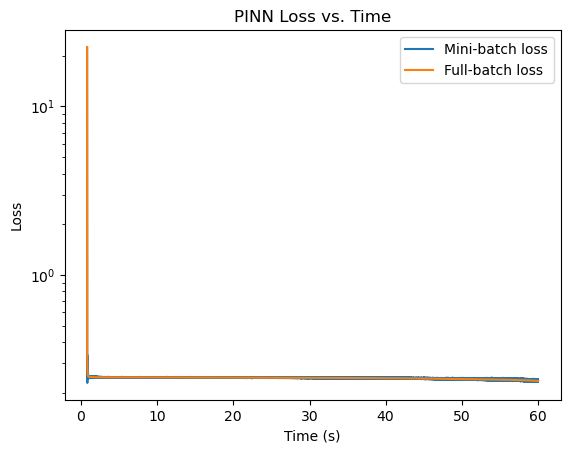

In [16]:
plt.plot(fullbatchloss_ls[:, 1], fullbatchloss_ls[:, 2], label='Mini-batch loss'); plt.yscale('log');
plt.plot(fullbatchloss_ls[:, 1], fullbatchloss_ls[:, 3], label='Full-batch loss');
plt.title('PINN Loss vs. Time'); plt.xlabel('Time (s)'); plt.ylabel('Loss'); plt.legend();

#### Visualize results

DeviceArray(0.15401918, dtype=float32)

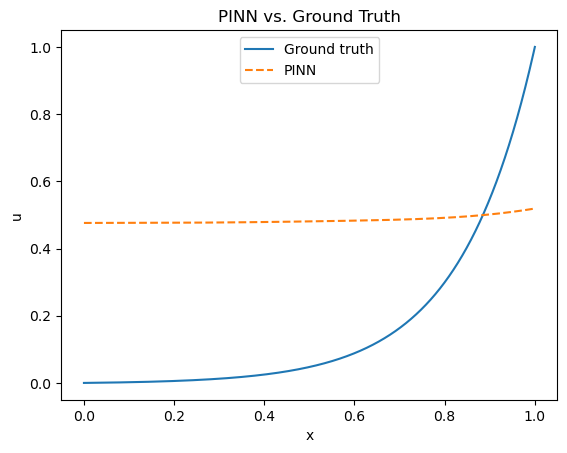

In [17]:
# plot result with best full-batch loss
hello = PINNs()
prediction = hello.apply(format_params_fn(papas[-1]), data_pde)
u = prediction[:,0:1]

plt.plot(x_pde, labels_pde, label = "Ground truth"); plt.plot(x_pde, u, '--', label = "PINN");
plt.legend(loc='upper center'); plt.title('PINN vs. Ground Truth'); plt.xlabel('x'); plt.ylabel('u');
jnp.mean(jnp.square(labels_pde - u))

Write PINN prediction & ground truth to file

In [18]:
#np.save('diffusion_sgd_minibatch_60s', (u, labels_pde))